# Project B_Report

## Data preprocessing

Get main shape of the impact and define the criteria to get this part.
Make sure the num. and exp. data are aligned and not in different timeframe.

In [1]:
import os
import pickle
import scipy.io
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt

In [2]:
def plot4Together(data, title):
    fig = plt.figure()
    fig.suptitle(title)

    axs = fig.subplots(2, 2)

    axs[0, 0].plot(data[:,0], data[:,1], 'tab:blue', label='1')
    axs[0, 0].ticklabel_format(axis='x', style='sci', scilimits=(-4,-4))
    axs[0, 0].yaxis.major.formatter._useMathText = True
    axs[0, 0].legend(loc='best')
    axs[0, 1].plot(data[:,0], data[:,2], 'tab:orange', label='2')
    axs[0, 1].ticklabel_format(axis='x', style='sci', scilimits=(-4,-4))
    axs[0, 1].yaxis.major.formatter._useMathText = True
    axs[0, 1].legend(loc='best')
    axs[1, 0].plot(data[:,0], data[:,3], 'tab:green', label='3')
    axs[1, 0].ticklabel_format(axis='x', style='sci', scilimits=(-4,-4))
    axs[1, 0].yaxis.major.formatter._useMathText = True
    axs[1, 0].legend(loc='best')
    axs[1, 1].plot(data[:,0], data[:,4], 'tab:purple', label='4')
    axs[1, 1].ticklabel_format(axis='x', style='sci', scilimits=(-4,-4))
    axs[1, 1].yaxis.major.formatter._useMathText = True
    axs[1, 1].legend(loc='best')

    fig.subplots_adjust(hspace=0.4)
    plt.show()
    
    pass

### Read data

In [3]:
def readAllNumerical(path):
    subjects = os.listdir(path)
    l = len(subjects)

    label = np.zeros((l, 2), dtype=int)
    dataset = []
    for i in range(l):
        file = scipy.io.loadmat(path + subjects[i])
        
        mat = file['num_data']
        dataset.append(mat)

        label[i, 0] = subjects[i][5:8]
        label[i, 1] = subjects[i][9:12]

    return dataset, label

In [4]:
def readAllExperiment(path):
    dirs = os.listdir(path)
    label = []
    dataset = []
    for j in range(len(dirs)):
        subs = os.listdir(path + '/' + dirs[j])
        for i in range(len(subs)):
            tmp_label = np.zeros(2, dtype=int)

            file = np.transpose(np.loadtxt(path + '/' + dirs[j] + '/' + subs[i], skiprows=8, unpack=True))
            
            # switch 3, 4 columns
            temp = np.copy(file[:, 3])
            file[:, 3] = file[:, 4]
            file[:, 4] = temp
            
            # flip data
            file[:, 1] = -file[:, 1]
            file[:, 2] = -file[:, 2]
            file[:, 3] = -file[:, 3]
            file[:, 4] = -file[:, 4]
            
            dataset.append(file)

            tmp_label[0] = subs[i][10:13]
            tmp_label[1] = subs[i][14:17]
        
            label.append(tmp_label)

    return dataset, label

In [5]:
def readExpTestData(path):
    subjects = os.listdir(path)

    ''' 
    # use to replace decimal system DE --> US
    for i in range(len(subjects)):
    #result = subjects[i].replace("'" , "")
    #filename = subjects.append(result)
    with open(path+subjects[i], 'r') as file:
        filedata = file.read()
        filedata = filedata.replace(',','.')

    with open(path+subjects[i],'w') as file:
        file.write(filedata)
    '''
    dataset = []
    for i in range(len(subjects)):
        
        #file = float(file.replace(',','.'))
        
        file = np.transpose(np.loadtxt(path + '/' + subjects[i], skiprows=8, unpack=True))
        
        # switch 3, 4 columns
        temp = np.copy(file[:, 3])
        file[:, 3] = file[:, 4]
        file[:, 4] = temp
        
        # flip data
        file[:, 1] = -file[:, 1]
        file[:, 2] = -file[:, 2]
        file[:, 3] = -file[:, 3]
        file[:, 4] = -file[:, 4]

        dataset.append(file)

    return dataset

### Cut data

The experiment data is very long hence we cut the data with later defined data points m and n.

In [6]:
def cutWholeData(data, m, n):
    x = data[:, 0]
    y1 = data[:, 1]
    y2 = data[:, 2]
    y3 = data[:, 3]
    y4 = data[:, 4]

    left = np.nonzero(x >  m)
    right = np.nonzero(x <= n)
    interval = np.intersect1d(left, right)

    x_new = x[interval]
    y_new1 = y1[interval]
    y_new2 = y2[interval]
    y_new3 = y3[interval]
    y_new4 = y4[interval]

    data_new = np.vstack([x_new[::10], y_new1[::10], y_new2[::10], y_new3[::10], y_new4[::10]])

    return data_new.T

### Resample experimental data

The numerical data time step, 1e-8, is different from the experiment data. So we resample experiment data to have same time step.

In [7]:
def reSample(data):
    x = data[:, 0]
    y1 = data[:, 1]
    y2 = data[:, 2]
    y3 = data[:, 3]
    y4 = data[:, 4]

    timeline = np.arange(x[0], x[-1], 1e-8)
    f1 = interpolate.interp1d(x, y1, kind='cubic', axis=- 1)
    y_new1 = f1(timeline)
    f2 = interpolate.interp1d(x, y2, kind='cubic', axis=- 1)
    y_new2 = f2(timeline)
    f3 = interpolate.interp1d(x, y3, kind='cubic', axis=- 1)
    y_new3 = f3(timeline)
    f4 = interpolate.interp1d(x, y4, kind='cubic', axis=- 1)
    y_new4 = f4(timeline)

    data_new = np.vstack([timeline, y_new1, y_new2, y_new3, y_new4])

    return data_new.T

### Align numerical and experimental data

We define limit value which sets a starting point where the amplitude is greater than the limit and take certain data points onwards.

In [8]:
def findEnd(y, limit):
    ind = np.nonzero(abs(y) < limit)
    ind_diff = np.diff(ind[0])
    tmp = np.nonzero(ind_diff > 1)
    end = tmp[0][0]

    return end


def alignNumData(data, limit, length, num):
    y1 = data[:, 1]
    y2 = data[:, 2]
    y3 = data[:, 3]
    y4 = data[:, 4]
    
    # find the starting point of the impact shape according to the limit intervall
    end1 = findEnd(y1, limit)
    end2 = findEnd(y2, limit)
    end3 = findEnd(y3, limit)
    end4 = findEnd(y4, limit)

    end = np.min(np.array([end1, end2, end3, end4]))     

    # select the impact area
    y_new1 = y1[end:end + length]
    y_new2 = y2[end:end + length]
    y_new3 = y3[end:end + length]
    y_new4 = y4[end:end + length]

    data_new = np.vstack([y_new1[::num], y_new2[::num], y_new3[::num], y_new4[::num]])

    return data_new.T


def alignExpData(data, m, n, limit, length, num):
    data0 = cutWholeData(data, m, n)
    tmp_data = reSample(data0)

    y1 = tmp_data[:, 1]
    y2 = tmp_data[:, 2]
    y3 = tmp_data[:, 3]
    y4 = tmp_data[:, 4]

    # find the starting point of the impact shape according to the limit intervall
    end1 = findEnd(y1, limit)
    end2 = findEnd(y2, limit)
    end3 = findEnd(y3, limit)
    end4 = findEnd(y4, limit)

    end = np.min(np.array([end1, end2, end3, end4]))

    # select the impact area
    y_new1 = y1[end:end + length]
    y_new2 = y2[end:end + length]
    y_new3 = y3[end:end + length]
    y_new4 = y4[end:end + length]

    data_new = np.vstack([y_new1[::num], y_new2[::num], y_new3[::num], y_new4[::num]])

    return data_new.T

### Augment data to get samples from different quadrants

We rearrange sensor location and make new labels.

In [9]:
def dataAugmentation(dataset, labels):
    ag_dataset = []
    ag_labels = []

    for i in range(len(dataset)):
        # split data for each sensor
        temp = dataset[i]   
        s1 = temp[:,0]
        s2 = temp[:,1]
        s3 = temp[:,2]
        s4 = temp[:,3]

        # rearrange for quadrant 2
        q2 = [s1,s4,s3,s2]
        # compute new labels
        q2_x = 500 - labels[i][0]
        q2_y = labels[i][1]
        l_q2 = [q2_x,q2_y]
        # reshape and store
        q2 = np.array(q2).T
        l_q2 = np.array(l_q2).T       
        ag_dataset.append(q2)
        ag_labels.append(l_q2)

        # rearrange for quadrant 3
        q3 = [s3,s4,s1,s2 ]
        # compute new labels
        q3_x = 500 - labels[i][0]
        q3_y = 500 - labels[i][1]
        l_q3 = [q3_x,q3_y]
        # reshape and store
        q3 = np.array(q3).T
        l_q3 = np.array(l_q3).T       
        ag_dataset.append(q3)
        ag_labels.append(l_q3)

        # rearrange for quadrant 4
        q4 = [s3,s2,s1,s4]
        # compute new labels
        q4_x = labels[i][0]
        q4_y = 500 - labels[i][1]
        l_q4 = [q4_x,q4_y]
        # reshape and store
        q4 = np.array(q4).T
        l_q4 = np.array(l_q4).T       
        ag_dataset.append(q4)
        ag_labels.append(l_q4)
    
    return ag_dataset, ag_labels

### Apply and generate pickle file 

In [10]:
# set limit criterion to assign starting point to sample data of same length
limit = 0.2
# *************************************** NUMERICAL DATA ***************************************
path1 = '../Data/EPOT_Data/'
dataset_num, label_num = readAllNumerical(path1)

# extract data points
outputfile_num = []
for i in range(len(dataset_num)):
    tmp0 = alignNumData(dataset_num[i], limit, 13000, 130)
    outputfile_num.append(tmp0)
    
outputfile_num = np.array(outputfile_num)
print(outputfile_num.shape)
print(label_num.shape)

# save to pickle
#f1 = open('num_input_[244,100,4]_' + str(limit) + '.pickle', 'wb+')
f1 = open('num_input_'+str(outputfile_num.shape)+'_'+ str(limit) + '.pickle', 'wb+')
pickle.dump(outputfile_num, f1)
f1.close()

#f2 = open('num_target_[244,2]_' + str(limit) + '.pickle', 'wb+')
f2 = open('num_target_'+str(label_num.shape)+'_' + str(limit) + '.pickle', 'wb+')
pickle.dump(label_num, f2)
f2.close()

# *************************************** AUGMENTED NUMERICAL DATA ***************************************
path1 = '../Data/EPOT_Data/'
dataset_num, label_num = readAllNumerical(path1)

# extract data points
outputfile_num = []
for i in range(len(dataset_num)):
    tmp0 = alignNumData(dataset_num[i], limit, 13000, 130)
    outputfile_num.append(tmp0)

# data augmentation 
ag_outputfile_num, ag_label_num = dataAugmentation(outputfile_num, label_num)

# merge Data
ag_label_num = np.array(ag_label_num)
label_augnum = np.concatenate((label_num, ag_label_num))
outputfile_num = np.array(outputfile_num)
ag_outputfile_num = np.array(ag_outputfile_num)
outputfile_augnum = np.concatenate((outputfile_num,ag_outputfile_num))

print(outputfile_augnum.shape)
print(label_augnum.shape)

# save to pickle
f3 = open('num_input_'+str(outputfile_augnum.shape)+'_'+ str(limit) + '.pickle', 'wb+')
pickle.dump(outputfile_augnum, f3)
f3.close()
f4 = open('num_target_'+str(label_augnum.shape)+'_' + str(limit) + '.pickle', 'wb+')
pickle.dump(label_augnum, f4)
f4.close()

# *************************************** EXPERIMENTAL DATA ***************************************
path2 = '../Data/Experimental_validation'

dataset_exp, label_exp = readAllExperiment(path2) 

# extract data points
outputfile_exp = []
for i in range(len(dataset_exp)):
    # tmp1 = cutData(dataset_exp[i])
    # tmp2 = reSample(tmp1)
    tmp3 = alignExpData(dataset_exp[i], 4995e-5, 5020e-5, limit, 13000, 130)
    outputfile_exp.append(tmp3)

outputfile_exp = np.array(outputfile_exp)
label_exp = np.array(label_exp)

print(outputfile_exp.shape)
print(label_exp.shape)

# save to pickle
f5 = open('exp_input_'+str(outputfile_exp.shape)+'_' + str(limit) + '.pickle', 'wb+')
pickle.dump(outputfile_exp, f5)
f5.close()

f6 = open('exp_target_'+str(label_exp.shape)+'_' + str(limit) + '.pickle', 'wb+')
pickle.dump(label_exp, f6)
f6.close()

# ******************************************* TEST DATA *******************************************
path3 = '../Data/Experimental_data/Group5'
dataset_test = readExpTestData(path3)

outputfile_test = []
for i in range(len(dataset_test)):
    tmp3 = alignExpData(dataset_test[i], 4995e-5, 5020e-5, limit, 13500, 135)
    outputfile_test.append(tmp3)

outputfile_test = np.array(outputfile_test)
print(outputfile_test.shape)

# save to pickle
f7 = open('test_input_'+str(outputfile_test.shape)+'_'+ str(limit) + '.pickle', 'wb+')
pickle.dump(outputfile_test, f7)
f7.close()

(244, 100, 4)
(244, 2)
(976, 100, 4)
(976, 2)
(24, 100, 4)
(24, 2)
(18, 100, 4)


# Neural Network

In [11]:
from tensorflow import keras
import pickle
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error as MAE
import seaborn as sns
import scipy.signal as sig

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [12]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [26]:
numerical_data = []
numerical_data_file = open(r'num_input_(976, 100, 4)_0.2.pickle', 'rb')
numerical_data.append(pickle.load(numerical_data_file))
numerical_data = (np.array(numerical_data).reshape((976,100,4)))
numerical_data_fcnn = numerical_data.reshape((976,400))
numerical_data_fcnn_60 = numerical_data[:,:60,:]
numerical_data_fcnn_60 = numerical_data_fcnn_60.reshape((976,240))

experimental_data = []
experimental_data_file = open(r'exp_input_(24, 100, 4)_0.2.pickle', 'rb')
experimental_data.append(pickle.load(experimental_data_file))
experimental_data = (np.array(experimental_data).reshape((24,100,4)))
experimental_data_fcnn = experimental_data.reshape((24,400))
experimental_data_fcnn_60 = experimental_data[:,:60,:]
experimental_data_fcnn_60 = experimental_data_fcnn_60.reshape((24,240))

#append the numerical_data to experimental_data and use it as the training data

numerical_label = []
numerical_label_file = open(r'num_target_(976, 2)_0.2.pickle', 'rb')
numerical_label.append(pickle.load(numerical_label_file))
numerical_label = np.array(numerical_label).reshape((976,2))

experimental_label = []
experimental_label_file = open(r'exp_target_(24, 2)_0.2.pickle', 'rb')
experimental_label.append(pickle.load(experimental_label_file))
experimental_label = np.array(experimental_label).reshape((24,2))


test_file = open("test_input_5(18, 100, 4)_0.2.pickle",'rb')
prediction_data = pickle.load(test_file)
test_file.close()
numerical_data_file.close()
experimental_data_file.close()
numerical_label_file.close()
experimental_label_file.close()


## FCNN

In [27]:
inputs = keras.Input(shape=(400,), name="input_layer")
x = layers.BatchNormalization()(inputs)
x = layers.Dropout(rate = 0.1)(x)
x = layers.Dense(128, activation="relu", name="dense_6", kernel_regularizer = "l2")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(rate = 0.1)(x)
x = layers.Dense(64, activation="relu", name="dense_7", kernel_regularizer = "l2")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(rate = 0.1)(x)
x = layers.Dense(16, activation="relu", name="dense_5", kernel_regularizer = "l2")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(rate = 0.1)(x)
x = layers.Dense(8, activation="relu", name="dense_4", kernel_regularizer = "l2")(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(2, name="predictions")(x)

In [28]:
model = keras.Model(inputs=inputs, outputs=outputs)

print(model.summary())

model.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # List of metrics to monitor
    metrics=[keras.metrics.MeanAbsoluteError()]
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 400)]             0         
                                                                 
 batch_normalization_5 (Batc  (None, 400)              1600      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 400)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               51328     
                                                                 
 batch_normalization_6 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 128)               0   

In [29]:
history = model.fit(
    numerical_data_fcnn,
    numerical_label,
    batch_size=40,
    epochs=600,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(experimental_data_fcnn, experimental_label),shuffle = True
)

Epoch 1/600
25/25 [==============================] - 1s 11ms/step - loss: 64459.1367 - mean_absolute_error: 249.9659 - val_loss: 57733.7070 - val_mean_absolute_error: 238.7906
Epoch 2/600
25/25 [==============================] - 0s 4ms/step - loss: 64365.8086 - mean_absolute_error: 249.8886 - val_loss: 57795.5977 - val_mean_absolute_error: 238.9687
Epoch 3/600
25/25 [==============================] - 0s 4ms/step - loss: 64291.3711 - mean_absolute_error: 249.7993 - val_loss: 57761.6445 - val_mean_absolute_error: 238.9383
Epoch 4/600
25/25 [==============================] - 0s 4ms/step - loss: 64209.0391 - mean_absolute_error: 249.6921 - val_loss: 57865.3633 - val_mean_absolute_error: 239.2231
Epoch 5/600
25/25 [==============================] - 0s 4ms/step - loss: 64117.7188 - mean_absolute_error: 249.5629 - val_loss: 57970.5977 - val_mean_absolute_error: 239.4794
Epoch 6/600
25/25 [==============================] - 0s 4ms/step - loss: 64016.7383 - mean_absolute_error: 249.4093 - val_lo

25/25 [==============================] - 0s 4ms/step - loss: 50874.1094 - mean_absolute_error: 223.4770 - val_loss: 49170.3164 - val_mean_absolute_error: 221.3052
Epoch 48/600
25/25 [==============================] - 0s 4ms/step - loss: 50402.2422 - mean_absolute_error: 222.4450 - val_loss: 48773.7461 - val_mean_absolute_error: 220.3989
Epoch 49/600
25/25 [==============================] - 0s 3ms/step - loss: 49941.5781 - mean_absolute_error: 221.3965 - val_loss: 47680.6992 - val_mean_absolute_error: 217.9016
Epoch 50/600
25/25 [==============================] - 0s 4ms/step - loss: 49455.0859 - mean_absolute_error: 220.3324 - val_loss: 47570.9492 - val_mean_absolute_error: 217.6596
Epoch 51/600
25/25 [==============================] - 0s 4ms/step - loss: 48970.6211 - mean_absolute_error: 219.2533 - val_loss: 46517.2344 - val_mean_absolute_error: 215.2496
Epoch 52/600
25/25 [==============================] - 0s 3ms/step - loss: 48490.8438 - mean_absolute_error: 218.1581 - val_loss: 4624

25/25 [==============================] - 0s 3ms/step - loss: 27335.2676 - mean_absolute_error: 162.9398 - val_loss: 26083.0371 - val_mean_absolute_error: 160.9797
Epoch 94/600
25/25 [==============================] - 0s 4ms/step - loss: 26829.4902 - mean_absolute_error: 161.4084 - val_loss: 25530.3594 - val_mean_absolute_error: 159.2721
Epoch 95/600
25/25 [==============================] - 0s 4ms/step - loss: 26333.9707 - mean_absolute_error: 159.8779 - val_loss: 25167.9688 - val_mean_absolute_error: 158.1098
Epoch 96/600
25/25 [==============================] - 0s 4ms/step - loss: 25837.0898 - mean_absolute_error: 158.3413 - val_loss: 24758.3926 - val_mean_absolute_error: 156.8154
Epoch 97/600
25/25 [==============================] - 0s 3ms/step - loss: 25349.8848 - mean_absolute_error: 156.7978 - val_loss: 24258.5488 - val_mean_absolute_error: 155.2283
Epoch 98/600
25/25 [==============================] - 0s 3ms/step - loss: 24866.6680 - mean_absolute_error: 155.2501 - val_loss: 2410

25/25 [==============================] - 0s 4ms/step - loss: 8898.7002 - mean_absolute_error: 90.7374 - val_loss: 8314.9600 - val_mean_absolute_error: 90.2786
Epoch 140/600
25/25 [==============================] - 0s 4ms/step - loss: 8598.0322 - mean_absolute_error: 89.2189 - val_loss: 8132.7388 - val_mean_absolute_error: 89.2635
Epoch 141/600
25/25 [==============================] - 0s 3ms/step - loss: 8344.2158 - mean_absolute_error: 87.7029 - val_loss: 7874.9429 - val_mean_absolute_error: 87.8286
Epoch 142/600
25/25 [==============================] - 0s 4ms/step - loss: 8078.7822 - mean_absolute_error: 86.1909 - val_loss: 7734.7598 - val_mean_absolute_error: 86.9710
Epoch 143/600
25/25 [==============================] - 0s 4ms/step - loss: 7823.4658 - mean_absolute_error: 84.6804 - val_loss: 7414.0181 - val_mean_absolute_error: 85.2166
Epoch 144/600
25/25 [==============================] - 0s 4ms/step - loss: 7556.0649 - mean_absolute_error: 83.1860 - val_loss: 6830.6733 - val_mean_

25/25 [==============================] - 0s 4ms/step - loss: 1369.9136 - mean_absolute_error: 31.5864 - val_loss: 989.1168 - val_mean_absolute_error: 30.0569
Epoch 187/600
25/25 [==============================] - 0s 4ms/step - loss: 1352.3741 - mean_absolute_error: 31.0175 - val_loss: 937.8592 - val_mean_absolute_error: 29.2386
Epoch 188/600
25/25 [==============================] - 0s 4ms/step - loss: 1246.6013 - mean_absolute_error: 29.9037 - val_loss: 885.3118 - val_mean_absolute_error: 28.0917
Epoch 189/600
25/25 [==============================] - 0s 4ms/step - loss: 1193.8817 - mean_absolute_error: 29.0909 - val_loss: 974.1072 - val_mean_absolute_error: 29.5871
Epoch 190/600
25/25 [==============================] - 0s 4ms/step - loss: 1145.5250 - mean_absolute_error: 28.5449 - val_loss: 916.6765 - val_mean_absolute_error: 28.5900
Epoch 191/600
25/25 [==============================] - 0s 4ms/step - loss: 1111.7280 - mean_absolute_error: 28.0331 - val_loss: 797.2226 - val_mean_absolu

25/25 [==============================] - 0s 4ms/step - loss: 223.4050 - mean_absolute_error: 11.6831 - val_loss: 75.6412 - val_mean_absolute_error: 7.0391
Epoch 235/600
25/25 [==============================] - 0s 4ms/step - loss: 191.9405 - mean_absolute_error: 10.9306 - val_loss: 76.3945 - val_mean_absolute_error: 7.1319
Epoch 236/600
25/25 [==============================] - 0s 4ms/step - loss: 199.4722 - mean_absolute_error: 11.2853 - val_loss: 68.9530 - val_mean_absolute_error: 6.7216
Epoch 237/600
25/25 [==============================] - 0s 4ms/step - loss: 199.7164 - mean_absolute_error: 11.0835 - val_loss: 75.7056 - val_mean_absolute_error: 6.9533
Epoch 238/600
25/25 [==============================] - 0s 4ms/step - loss: 197.8687 - mean_absolute_error: 10.8730 - val_loss: 82.6264 - val_mean_absolute_error: 7.2759
Epoch 239/600
25/25 [==============================] - 0s 4ms/step - loss: 182.2467 - mean_absolute_error: 10.4498 - val_loss: 69.9092 - val_mean_absolute_error: 6.2408


Epoch 283/600
25/25 [==============================] - 0s 4ms/step - loss: 137.1216 - mean_absolute_error: 8.9929 - val_loss: 40.9556 - val_mean_absolute_error: 4.2412
Epoch 284/600
25/25 [==============================] - 0s 4ms/step - loss: 130.5720 - mean_absolute_error: 8.8446 - val_loss: 36.5945 - val_mean_absolute_error: 4.0750
Epoch 285/600
25/25 [==============================] - 0s 4ms/step - loss: 108.2801 - mean_absolute_error: 7.9847 - val_loss: 36.7119 - val_mean_absolute_error: 4.4514
Epoch 286/600
25/25 [==============================] - 0s 4ms/step - loss: 132.4907 - mean_absolute_error: 8.8985 - val_loss: 35.6021 - val_mean_absolute_error: 4.1539
Epoch 287/600
25/25 [==============================] - 0s 4ms/step - loss: 123.1913 - mean_absolute_error: 8.5056 - val_loss: 36.4017 - val_mean_absolute_error: 4.1959
Epoch 288/600
25/25 [==============================] - 0s 4ms/step - loss: 123.4843 - mean_absolute_error: 8.6444 - val_loss: 38.4982 - val_mean_absolute_error:

Epoch 332/600
25/25 [==============================] - 0s 4ms/step - loss: 122.4963 - mean_absolute_error: 8.4096 - val_loss: 36.6393 - val_mean_absolute_error: 3.9598
Epoch 333/600
25/25 [==============================] - 0s 4ms/step - loss: 140.5028 - mean_absolute_error: 9.1250 - val_loss: 40.8537 - val_mean_absolute_error: 4.6157
Epoch 334/600
25/25 [==============================] - 0s 4ms/step - loss: 124.6612 - mean_absolute_error: 8.7001 - val_loss: 33.5171 - val_mean_absolute_error: 3.9340
Epoch 335/600
25/25 [==============================] - 0s 4ms/step - loss: 117.3960 - mean_absolute_error: 8.2672 - val_loss: 38.3132 - val_mean_absolute_error: 4.4266
Epoch 336/600
25/25 [==============================] - 0s 4ms/step - loss: 133.0146 - mean_absolute_error: 8.7731 - val_loss: 26.6655 - val_mean_absolute_error: 3.5071
Epoch 337/600
25/25 [==============================] - 0s 4ms/step - loss: 145.8262 - mean_absolute_error: 9.2331 - val_loss: 24.3087 - val_mean_absolute_error:

Epoch 381/600
25/25 [==============================] - 0s 6ms/step - loss: 105.8573 - mean_absolute_error: 7.7720 - val_loss: 36.6880 - val_mean_absolute_error: 4.0910
Epoch 382/600
25/25 [==============================] - 0s 4ms/step - loss: 108.8168 - mean_absolute_error: 8.0857 - val_loss: 37.7744 - val_mean_absolute_error: 3.8193
Epoch 383/600
25/25 [==============================] - 0s 4ms/step - loss: 124.5078 - mean_absolute_error: 8.6022 - val_loss: 37.8225 - val_mean_absolute_error: 4.1579
Epoch 384/600
25/25 [==============================] - 0s 4ms/step - loss: 112.7759 - mean_absolute_error: 8.1189 - val_loss: 37.5512 - val_mean_absolute_error: 4.3271
Epoch 385/600
25/25 [==============================] - 0s 4ms/step - loss: 117.1831 - mean_absolute_error: 8.2491 - val_loss: 45.3127 - val_mean_absolute_error: 4.9819
Epoch 386/600
25/25 [==============================] - 0s 4ms/step - loss: 100.8658 - mean_absolute_error: 7.7068 - val_loss: 48.2029 - val_mean_absolute_error:

Epoch 430/600
25/25 [==============================] - 0s 4ms/step - loss: 120.5063 - mean_absolute_error: 8.4057 - val_loss: 38.1367 - val_mean_absolute_error: 5.0388
Epoch 431/600
25/25 [==============================] - 0s 4ms/step - loss: 108.5273 - mean_absolute_error: 7.8338 - val_loss: 33.8870 - val_mean_absolute_error: 4.5701
Epoch 432/600
25/25 [==============================] - 0s 5ms/step - loss: 113.6917 - mean_absolute_error: 7.8083 - val_loss: 30.8589 - val_mean_absolute_error: 4.2921
Epoch 433/600
25/25 [==============================] - 0s 5ms/step - loss: 108.0040 - mean_absolute_error: 7.8402 - val_loss: 34.0421 - val_mean_absolute_error: 4.6897
Epoch 434/600
25/25 [==============================] - 0s 5ms/step - loss: 121.0531 - mean_absolute_error: 8.3087 - val_loss: 25.3887 - val_mean_absolute_error: 3.8388
Epoch 435/600
25/25 [==============================] - 0s 4ms/step - loss: 110.6212 - mean_absolute_error: 8.0975 - val_loss: 35.7557 - val_mean_absolute_error:

Epoch 479/600
25/25 [==============================] - 0s 4ms/step - loss: 100.1533 - mean_absolute_error: 7.6538 - val_loss: 42.0949 - val_mean_absolute_error: 4.6678
Epoch 480/600
25/25 [==============================] - 0s 5ms/step - loss: 116.3756 - mean_absolute_error: 8.0691 - val_loss: 44.2427 - val_mean_absolute_error: 5.0122
Epoch 481/600
25/25 [==============================] - 0s 5ms/step - loss: 127.9042 - mean_absolute_error: 8.5377 - val_loss: 41.7330 - val_mean_absolute_error: 4.8838
Epoch 482/600
25/25 [==============================] - 0s 4ms/step - loss: 131.4913 - mean_absolute_error: 8.7951 - val_loss: 37.0863 - val_mean_absolute_error: 4.6708
Epoch 483/600
25/25 [==============================] - 0s 4ms/step - loss: 116.1434 - mean_absolute_error: 8.2860 - val_loss: 33.5850 - val_mean_absolute_error: 4.5318
Epoch 484/600
25/25 [==============================] - 0s 4ms/step - loss: 113.0089 - mean_absolute_error: 8.1819 - val_loss: 35.1017 - val_mean_absolute_error:

Epoch 528/600
25/25 [==============================] - 0s 4ms/step - loss: 129.0312 - mean_absolute_error: 8.6743 - val_loss: 40.2648 - val_mean_absolute_error: 4.6101
Epoch 529/600
25/25 [==============================] - 0s 4ms/step - loss: 114.4046 - mean_absolute_error: 8.3279 - val_loss: 39.1253 - val_mean_absolute_error: 4.6314
Epoch 530/600
25/25 [==============================] - 0s 4ms/step - loss: 111.3515 - mean_absolute_error: 8.0561 - val_loss: 38.7801 - val_mean_absolute_error: 4.5624
Epoch 531/600
25/25 [==============================] - 0s 4ms/step - loss: 111.2307 - mean_absolute_error: 7.9456 - val_loss: 32.8075 - val_mean_absolute_error: 4.0987
Epoch 532/600
25/25 [==============================] - 0s 4ms/step - loss: 89.8332 - mean_absolute_error: 7.2251 - val_loss: 33.8681 - val_mean_absolute_error: 4.4470
Epoch 533/600
25/25 [==============================] - 0s 4ms/step - loss: 103.0890 - mean_absolute_error: 7.6342 - val_loss: 33.7578 - val_mean_absolute_error: 

Epoch 577/600
25/25 [==============================] - 0s 4ms/step - loss: 108.7526 - mean_absolute_error: 7.9707 - val_loss: 50.0035 - val_mean_absolute_error: 5.8187
Epoch 578/600
25/25 [==============================] - 0s 4ms/step - loss: 104.4379 - mean_absolute_error: 7.9585 - val_loss: 46.5689 - val_mean_absolute_error: 5.5164
Epoch 579/600
25/25 [==============================] - 0s 4ms/step - loss: 109.8475 - mean_absolute_error: 8.0645 - val_loss: 42.7854 - val_mean_absolute_error: 5.3686
Epoch 580/600
25/25 [==============================] - 0s 4ms/step - loss: 122.7212 - mean_absolute_error: 8.3660 - val_loss: 52.5383 - val_mean_absolute_error: 5.8785
Epoch 581/600
25/25 [==============================] - 0s 4ms/step - loss: 116.8114 - mean_absolute_error: 8.3191 - val_loss: 48.0295 - val_mean_absolute_error: 5.6474
Epoch 582/600
25/25 [==============================] - 0s 4ms/step - loss: 131.8860 - mean_absolute_error: 8.9495 - val_loss: 37.2076 - val_mean_absolute_error:

### Test on FCNN

In [30]:
actual = np.matrix([[250, 265],
                   [265, 235],
                   [235, 235],
                   [245, 255],
                   [255, 265],
                   [250, 250],
                   [200, 225],
                   [225, 200],
                   [270, 300],
                   [250, 250],
                   [265, 235],
                   [235, 300],
                   [265, 255],
                   [235, 235],
                   [250, 265],
                   [260, 320],
                   [245, 255],
                   [300, 285]])

In [31]:
prediction_data_fcnn = prediction_data.reshape(18,400)

In [32]:
prediction_fcnn = model.predict(prediction_data_fcnn)

In [33]:
MAE(actual, prediction_fcnn)

5.629074520534939

## FCNN with 60% of input

In [34]:
numerical_data_fcnn_60 = numerical_data[:,:60,:]
numerical_data_fcnn_60 = numerical_data_fcnn_60.reshape((976,240))
experimental_data_fcnn_60 = experimental_data[:,:60,:]
experimental_data_fcnn_60 = experimental_data_fcnn_60.reshape((24,240))

In [35]:
inputs = keras.Input(shape=(240,), name="input_layer")
x = layers.BatchNormalization()(inputs)
x = layers.Dropout(rate = 0.1)(x)
x = layers.Dense(128, activation="relu", name="dense_6", kernel_regularizer = "l2")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(rate = 0.1)(x)
x = layers.Dense(64, activation="relu", name="dense_7", kernel_regularizer = "l2")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(rate = 0.1)(x)
x = layers.Dense(16, activation="relu", name="dense_5", kernel_regularizer = "l2")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(rate = 0.1)(x)
x = layers.Dense(8, activation="relu", name="dense_4", kernel_regularizer = "l2")(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(2, name="predictions")(x)

In [36]:
model = keras.Model(inputs=inputs, outputs=outputs)

print(model.summary())

model.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # List of metrics to monitor
    metrics=[keras.metrics.MeanAbsoluteError()]
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 240)]             0         
                                                                 
 batch_normalization_10 (Bat  (None, 240)              960       
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 240)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               30848     
                                                                 
 batch_normalization_11 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 128)               0   

In [37]:
history = model.fit(
    numerical_data_fcnn_60,
    numerical_label,
    batch_size=40,
    epochs=600,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(experimental_data_fcnn_60, experimental_label),shuffle = True
)

Epoch 1/600
25/25 [==============================] - 1s 11ms/step - loss: 64473.8398 - mean_absolute_error: 249.9700 - val_loss: 58234.0273 - val_mean_absolute_error: 239.8997
Epoch 2/600
25/25 [==============================] - 0s 4ms/step - loss: 64382.0312 - mean_absolute_error: 249.9018 - val_loss: 58209.6055 - val_mean_absolute_error: 239.8809
Epoch 3/600
25/25 [==============================] - 0s 4ms/step - loss: 64308.4922 - mean_absolute_error: 249.8232 - val_loss: 58111.7383 - val_mean_absolute_error: 239.6944
Epoch 4/600
25/25 [==============================] - 0s 4ms/step - loss: 64225.7852 - mean_absolute_error: 249.7290 - val_loss: 58115.7773 - val_mean_absolute_error: 239.7297
Epoch 5/600
25/25 [==============================] - 0s 4ms/step - loss: 64137.6562 - mean_absolute_error: 249.6144 - val_loss: 58064.5039 - val_mean_absolute_error: 239.6888
Epoch 6/600
25/25 [==============================] - 0s 4ms/step - loss: 64040.8945 - mean_absolute_error: 249.4753 - val_lo

25/25 [==============================] - 0s 3ms/step - loss: 50753.9336 - mean_absolute_error: 223.3298 - val_loss: 49260.7188 - val_mean_absolute_error: 221.6064
Epoch 48/600
25/25 [==============================] - 0s 3ms/step - loss: 50274.2656 - mean_absolute_error: 222.2924 - val_loss: 48782.8945 - val_mean_absolute_error: 220.4950
Epoch 49/600
25/25 [==============================] - 0s 3ms/step - loss: 49796.1328 - mean_absolute_error: 221.2386 - val_loss: 48381.7812 - val_mean_absolute_error: 219.6168
Epoch 50/600
25/25 [==============================] - 0s 3ms/step - loss: 49322.6680 - mean_absolute_error: 220.1675 - val_loss: 46728.3867 - val_mean_absolute_error: 215.7545
Epoch 51/600
25/25 [==============================] - 0s 3ms/step - loss: 48839.6289 - mean_absolute_error: 219.0835 - val_loss: 47189.3164 - val_mean_absolute_error: 216.9116
Epoch 52/600
25/25 [==============================] - 0s 3ms/step - loss: 48347.5117 - mean_absolute_error: 217.9864 - val_loss: 4680

25/25 [==============================] - 0s 3ms/step - loss: 27138.4668 - mean_absolute_error: 162.6869 - val_loss: 26330.3535 - val_mean_absolute_error: 161.8724
Epoch 94/600
25/25 [==============================] - 0s 3ms/step - loss: 26635.9453 - mean_absolute_error: 161.1621 - val_loss: 26339.1035 - val_mean_absolute_error: 161.8413
Epoch 95/600
25/25 [==============================] - 0s 3ms/step - loss: 26163.1367 - mean_absolute_error: 159.6273 - val_loss: 24899.5957 - val_mean_absolute_error: 157.3561
Epoch 96/600
25/25 [==============================] - 0s 3ms/step - loss: 25651.5566 - mean_absolute_error: 158.0900 - val_loss: 25263.6348 - val_mean_absolute_error: 158.4976
Epoch 97/600
25/25 [==============================] - 0s 3ms/step - loss: 25177.6621 - mean_absolute_error: 156.5439 - val_loss: 24220.6660 - val_mean_absolute_error: 155.1893
Epoch 98/600
25/25 [==============================] - 0s 3ms/step - loss: 24678.5566 - mean_absolute_error: 154.9918 - val_loss: 2387

25/25 [==============================] - 0s 3ms/step - loss: 8735.2588 - mean_absolute_error: 90.4310 - val_loss: 8317.1016 - val_mean_absolute_error: 90.6936
Epoch 140/600
25/25 [==============================] - 0s 3ms/step - loss: 8437.4453 - mean_absolute_error: 88.9095 - val_loss: 8181.1382 - val_mean_absolute_error: 89.7478
Epoch 141/600
25/25 [==============================] - 0s 3ms/step - loss: 8165.6846 - mean_absolute_error: 87.3938 - val_loss: 7638.4902 - val_mean_absolute_error: 86.7954
Epoch 142/600
25/25 [==============================] - 0s 3ms/step - loss: 7917.1348 - mean_absolute_error: 85.8860 - val_loss: 7418.9824 - val_mean_absolute_error: 85.3610
Epoch 143/600
25/25 [==============================] - 0s 3ms/step - loss: 7657.9551 - mean_absolute_error: 84.3752 - val_loss: 7034.7925 - val_mean_absolute_error: 83.1128
Epoch 144/600
25/25 [==============================] - 0s 3ms/step - loss: 7394.0483 - mean_absolute_error: 82.8681 - val_loss: 7086.3691 - val_mean_

25/25 [==============================] - 0s 3ms/step - loss: 1258.4431 - mean_absolute_error: 30.9423 - val_loss: 1072.5913 - val_mean_absolute_error: 32.0791
Epoch 187/600
25/25 [==============================] - 0s 3ms/step - loss: 1207.2843 - mean_absolute_error: 29.9193 - val_loss: 1036.3781 - val_mean_absolute_error: 31.4701
Epoch 188/600
25/25 [==============================] - 0s 3ms/step - loss: 1147.3003 - mean_absolute_error: 29.3923 - val_loss: 951.7228 - val_mean_absolute_error: 29.8825
Epoch 189/600
25/25 [==============================] - 0s 4ms/step - loss: 1091.6405 - mean_absolute_error: 28.2947 - val_loss: 877.4822 - val_mean_absolute_error: 28.5891
Epoch 190/600
25/25 [==============================] - 0s 3ms/step - loss: 1044.1986 - mean_absolute_error: 27.6606 - val_loss: 863.1521 - val_mean_absolute_error: 28.4704
Epoch 191/600
25/25 [==============================] - 0s 3ms/step - loss: 1000.4941 - mean_absolute_error: 26.9599 - val_loss: 798.6965 - val_mean_abso

Epoch 234/600
25/25 [==============================] - 0s 3ms/step - loss: 189.3636 - mean_absolute_error: 10.8075 - val_loss: 56.6768 - val_mean_absolute_error: 6.3830
Epoch 235/600
25/25 [==============================] - 0s 3ms/step - loss: 194.4291 - mean_absolute_error: 10.9349 - val_loss: 71.5667 - val_mean_absolute_error: 7.1960
Epoch 236/600
25/25 [==============================] - 0s 3ms/step - loss: 178.0154 - mean_absolute_error: 10.3903 - val_loss: 93.8404 - val_mean_absolute_error: 8.1891
Epoch 237/600
25/25 [==============================] - 0s 3ms/step - loss: 193.3021 - mean_absolute_error: 10.7845 - val_loss: 108.6970 - val_mean_absolute_error: 9.0805
Epoch 238/600
25/25 [==============================] - 0s 3ms/step - loss: 173.6885 - mean_absolute_error: 10.2528 - val_loss: 78.4524 - val_mean_absolute_error: 7.4556
Epoch 239/600
25/25 [==============================] - 0s 3ms/step - loss: 187.9544 - mean_absolute_error: 10.7029 - val_loss: 94.3763 - val_mean_absolute

Epoch 283/600
25/25 [==============================] - 0s 3ms/step - loss: 122.6045 - mean_absolute_error: 8.4249 - val_loss: 42.4889 - val_mean_absolute_error: 4.8006
Epoch 284/600
25/25 [==============================] - 0s 3ms/step - loss: 134.2073 - mean_absolute_error: 8.9241 - val_loss: 53.4959 - val_mean_absolute_error: 5.7822
Epoch 285/600
25/25 [==============================] - 0s 3ms/step - loss: 123.1333 - mean_absolute_error: 8.5359 - val_loss: 51.6343 - val_mean_absolute_error: 5.8854
Epoch 286/600
25/25 [==============================] - 0s 3ms/step - loss: 141.9600 - mean_absolute_error: 9.3647 - val_loss: 43.6491 - val_mean_absolute_error: 4.8115
Epoch 287/600
25/25 [==============================] - 0s 4ms/step - loss: 113.2066 - mean_absolute_error: 8.2250 - val_loss: 55.0788 - val_mean_absolute_error: 5.9475
Epoch 288/600
25/25 [==============================] - 0s 3ms/step - loss: 111.9293 - mean_absolute_error: 8.1873 - val_loss: 39.5039 - val_mean_absolute_error:

Epoch 332/600
25/25 [==============================] - 0s 4ms/step - loss: 125.5361 - mean_absolute_error: 8.6044 - val_loss: 43.5589 - val_mean_absolute_error: 4.8891
Epoch 333/600
25/25 [==============================] - 0s 4ms/step - loss: 128.3632 - mean_absolute_error: 8.5918 - val_loss: 41.7391 - val_mean_absolute_error: 4.4843
Epoch 334/600
25/25 [==============================] - 0s 4ms/step - loss: 119.9363 - mean_absolute_error: 8.5623 - val_loss: 46.0693 - val_mean_absolute_error: 4.9257
Epoch 335/600
25/25 [==============================] - 0s 4ms/step - loss: 128.5447 - mean_absolute_error: 8.5539 - val_loss: 52.7740 - val_mean_absolute_error: 5.5434
Epoch 336/600
25/25 [==============================] - 0s 4ms/step - loss: 128.6908 - mean_absolute_error: 8.7849 - val_loss: 38.7322 - val_mean_absolute_error: 4.3242
Epoch 337/600
25/25 [==============================] - 0s 4ms/step - loss: 130.0586 - mean_absolute_error: 8.8274 - val_loss: 56.4671 - val_mean_absolute_error:

Epoch 381/600
25/25 [==============================] - 0s 3ms/step - loss: 126.4699 - mean_absolute_error: 8.7578 - val_loss: 43.0330 - val_mean_absolute_error: 4.8236
Epoch 382/600
25/25 [==============================] - 0s 3ms/step - loss: 116.4035 - mean_absolute_error: 8.2290 - val_loss: 48.4512 - val_mean_absolute_error: 5.1384
Epoch 383/600
25/25 [==============================] - 0s 3ms/step - loss: 120.7455 - mean_absolute_error: 8.3291 - val_loss: 48.9969 - val_mean_absolute_error: 5.0918
Epoch 384/600
25/25 [==============================] - 0s 3ms/step - loss: 133.8790 - mean_absolute_error: 8.8895 - val_loss: 43.0016 - val_mean_absolute_error: 4.7225
Epoch 385/600
25/25 [==============================] - 0s 3ms/step - loss: 108.6767 - mean_absolute_error: 7.8322 - val_loss: 42.1786 - val_mean_absolute_error: 4.4564
Epoch 386/600
25/25 [==============================] - 0s 3ms/step - loss: 119.1118 - mean_absolute_error: 8.3840 - val_loss: 46.5445 - val_mean_absolute_error:

Epoch 430/600
25/25 [==============================] - 0s 3ms/step - loss: 109.1238 - mean_absolute_error: 7.9802 - val_loss: 68.6515 - val_mean_absolute_error: 6.5988
Epoch 431/600
25/25 [==============================] - 0s 3ms/step - loss: 124.4486 - mean_absolute_error: 8.6395 - val_loss: 40.5072 - val_mean_absolute_error: 4.9939
Epoch 432/600
25/25 [==============================] - 0s 4ms/step - loss: 130.4462 - mean_absolute_error: 8.6921 - val_loss: 41.7417 - val_mean_absolute_error: 5.0728
Epoch 433/600
25/25 [==============================] - 0s 4ms/step - loss: 130.4188 - mean_absolute_error: 8.7478 - val_loss: 54.2387 - val_mean_absolute_error: 5.9612
Epoch 434/600
25/25 [==============================] - 0s 3ms/step - loss: 125.2828 - mean_absolute_error: 8.5109 - val_loss: 48.1357 - val_mean_absolute_error: 5.4956
Epoch 435/600
25/25 [==============================] - 0s 3ms/step - loss: 110.3401 - mean_absolute_error: 8.0982 - val_loss: 46.2276 - val_mean_absolute_error:

Epoch 479/600
25/25 [==============================] - 0s 3ms/step - loss: 132.6590 - mean_absolute_error: 8.7464 - val_loss: 56.9106 - val_mean_absolute_error: 6.0823
Epoch 480/600
25/25 [==============================] - 0s 3ms/step - loss: 110.7841 - mean_absolute_error: 7.9833 - val_loss: 45.0352 - val_mean_absolute_error: 5.3367
Epoch 481/600
25/25 [==============================] - 0s 3ms/step - loss: 112.8512 - mean_absolute_error: 8.1847 - val_loss: 35.4446 - val_mean_absolute_error: 4.6481
Epoch 482/600
25/25 [==============================] - 0s 3ms/step - loss: 112.0481 - mean_absolute_error: 8.2092 - val_loss: 30.0140 - val_mean_absolute_error: 4.1131
Epoch 483/600
25/25 [==============================] - 0s 3ms/step - loss: 132.0065 - mean_absolute_error: 8.6464 - val_loss: 33.0164 - val_mean_absolute_error: 4.0910
Epoch 484/600
25/25 [==============================] - 0s 3ms/step - loss: 102.9127 - mean_absolute_error: 7.6672 - val_loss: 40.8136 - val_mean_absolute_error:

Epoch 528/600
25/25 [==============================] - 0s 3ms/step - loss: 126.7239 - mean_absolute_error: 8.6177 - val_loss: 37.0591 - val_mean_absolute_error: 4.5278
Epoch 529/600
25/25 [==============================] - 0s 3ms/step - loss: 114.2422 - mean_absolute_error: 8.2173 - val_loss: 37.8894 - val_mean_absolute_error: 4.8242
Epoch 530/600
25/25 [==============================] - 0s 3ms/step - loss: 119.6259 - mean_absolute_error: 8.3330 - val_loss: 39.8520 - val_mean_absolute_error: 4.9028
Epoch 531/600
25/25 [==============================] - 0s 3ms/step - loss: 101.1029 - mean_absolute_error: 7.6380 - val_loss: 29.4880 - val_mean_absolute_error: 4.0219
Epoch 532/600
25/25 [==============================] - 0s 3ms/step - loss: 103.0721 - mean_absolute_error: 7.8102 - val_loss: 37.0396 - val_mean_absolute_error: 4.5618
Epoch 533/600
25/25 [==============================] - 0s 4ms/step - loss: 121.3348 - mean_absolute_error: 8.6379 - val_loss: 36.0345 - val_mean_absolute_error:

Epoch 577/600
25/25 [==============================] - 0s 3ms/step - loss: 122.8414 - mean_absolute_error: 8.1739 - val_loss: 60.6185 - val_mean_absolute_error: 5.1580
Epoch 578/600
25/25 [==============================] - 0s 3ms/step - loss: 111.7585 - mean_absolute_error: 8.0118 - val_loss: 51.7349 - val_mean_absolute_error: 5.4492
Epoch 579/600
25/25 [==============================] - 0s 3ms/step - loss: 131.9633 - mean_absolute_error: 8.6275 - val_loss: 59.0842 - val_mean_absolute_error: 5.6056
Epoch 580/600
25/25 [==============================] - 0s 3ms/step - loss: 124.6439 - mean_absolute_error: 8.5780 - val_loss: 60.4281 - val_mean_absolute_error: 5.4483
Epoch 581/600
25/25 [==============================] - 0s 3ms/step - loss: 124.0480 - mean_absolute_error: 8.3725 - val_loss: 45.8524 - val_mean_absolute_error: 4.9374
Epoch 582/600
25/25 [==============================] - 0s 3ms/step - loss: 119.8008 - mean_absolute_error: 8.4600 - val_loss: 62.9133 - val_mean_absolute_error:

### Test on FCNN with 60% of input

In [38]:
prediction_data_fcnn_60 = prediction_data[:,:60,:].reshape(18,240)
prediction_fcnn_60 = model.predict(prediction_data_fcnn_60)
MAE(actual, prediction_fcnn_60)

5.762058258056641

## Wavelet Transform

In [39]:
num_data_with_wavelet = np.zeros((976, 100, 4, 4))

for index_i_num in range(976):
    for index_j_num in range(4):
        num_data = sig.cwt(numerical_data[index_i_num,:,index_j_num], sig.ricker, widths = (3, 5,7,10))  #shape = (5, 100)
        num_data_with_wavelet[index_i_num, :, index_j_num, :] = np.transpose(num_data)
num_data_with_wavelet = np.concatenate((numerical_data[:,:,:,np.newaxis], num_data_with_wavelet), axis = 3)

exp_data_with_wavelet = np.zeros((24, 100, 4, 4))
for index_i_exp in range(24):
    for index_j_exp in range(4):
        exp_data = sig.cwt(experimental_data[index_i_exp,:,index_j_exp], sig.ricker, widths = (3,5,7,10))  #shape = (5, 100)
        exp_data_with_wavelet[index_i_exp, :, index_j_exp, :] = np.transpose(exp_data)
        
exp_data_with_wavelet = np.concatenate((experimental_data[:,:,:,np.newaxis], exp_data_with_wavelet), axis = 3)        

## CNN

In [40]:
inputs = keras.Input(shape=(100, 4, 5), name="input_layer")
x = layers.BatchNormalization()(inputs)
x1 = layers.Conv2D(16, kernel_size = (2,4), activation = "relu", kernel_regularizer = "l2", padding = "same")(x)
x2 = layers.BatchNormalization()(x1)
x3 = layers.Dropout(rate = 0.2)(x2)
x4 = layers.Conv2D(8, kernel_size = (4,1), activation = "relu", kernel_regularizer = "l2", padding = "same")(x3)
x5 = layers.BatchNormalization()(x4)
x6 = layers.Dropout(rate = 0.2)(x5)
x7 = layers.Conv2D(16, kernel_size = (8,1), activation = "relu", kernel_regularizer = "l2", padding = "same")(x6)
x8 = layers.Add()([x7, x1])
x9 = layers.Flatten()(x8)
x10 = layers.Dense(32, kernel_regularizer = "l2")(x9)
x11 = layers.BatchNormalization()(x10)
x12 = layers.Dropout(rate = 0.2)(x11)
x13 = layers.Dense(16, kernel_regularizer = "l2")(x12)
x14= layers.BatchNormalization()(x13)
x15 = layers.Dense(8, kernel_regularizer = "l2")(x14)
outputs = layers.Dense(2, kernel_regularizer = "l2")(x15)

In [41]:
model = keras.Model(inputs=inputs, outputs=outputs)

print(model.summary())

model.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # List of metrics to monitor
    metrics=[keras.metrics.MeanAbsoluteError()]
)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 100, 4, 5)]  0           []                               
                                                                                                  
 batch_normalization_15 (BatchN  (None, 100, 4, 5)   20          ['input_layer[0][0]']            
 ormalization)                                                                                    
                                                                                                  
 conv2d (Conv2D)                (None, 100, 4, 16)   656         ['batch_normalization_15[0][0]'] 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 100, 4, 16)  64          ['conv2d[0][0]']           

In [42]:
history = model.fit(
    num_data_with_wavelet,
    numerical_label,
    batch_size=40,
    epochs=600,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(exp_data_with_wavelet, experimental_label),shuffle = True
)

Epoch 1/600
25/25 [==============================] - 2s 39ms/step - loss: 64280.0977 - mean_absolute_error: 249.9257 - val_loss: 58503.1133 - val_mean_absolute_error: 241.2840
Epoch 2/600
25/25 [==============================] - 1s 31ms/step - loss: 64040.2734 - mean_absolute_error: 249.7317 - val_loss: 60151.5742 - val_mean_absolute_error: 244.7253
Epoch 3/600
25/25 [==============================] - 1s 33ms/step - loss: 63790.5000 - mean_absolute_error: 249.4524 - val_loss: 59346.8750 - val_mean_absolute_error: 243.1273
Epoch 4/600
25/25 [==============================] - 1s 37ms/step - loss: 63473.7773 - mean_absolute_error: 249.0443 - val_loss: 59034.4258 - val_mean_absolute_error: 242.5828
Epoch 5/600
25/25 [==============================] - 1s 35ms/step - loss: 63045.5625 - mean_absolute_error: 248.4472 - val_loss: 58353.1055 - val_mean_absolute_error: 241.1971
Epoch 6/600
25/25 [==============================] - 1s 30ms/step - loss: 62484.7500 - mean_absolute_error: 247.5871 - v

25/25 [==============================] - 1s 32ms/step - loss: 111.2124 - mean_absolute_error: 8.1720 - val_loss: 89.9230 - val_mean_absolute_error: 7.5869
Epoch 49/600
25/25 [==============================] - 1s 33ms/step - loss: 102.6162 - mean_absolute_error: 7.8116 - val_loss: 78.6630 - val_mean_absolute_error: 7.0795
Epoch 50/600
25/25 [==============================] - 1s 34ms/step - loss: 117.4642 - mean_absolute_error: 8.3883 - val_loss: 87.3470 - val_mean_absolute_error: 7.6147
Epoch 51/600
25/25 [==============================] - 1s 31ms/step - loss: 108.8112 - mean_absolute_error: 8.2848 - val_loss: 96.8361 - val_mean_absolute_error: 7.8059
Epoch 52/600
25/25 [==============================] - 1s 32ms/step - loss: 121.6778 - mean_absolute_error: 8.5402 - val_loss: 88.1306 - val_mean_absolute_error: 7.5823
Epoch 53/600
25/25 [==============================] - 1s 35ms/step - loss: 119.4744 - mean_absolute_error: 8.5396 - val_loss: 71.6263 - val_mean_absolute_error: 6.8704
Epoch

Epoch 97/600
25/25 [==============================] - 1s 32ms/step - loss: 116.3258 - mean_absolute_error: 8.3637 - val_loss: 91.3716 - val_mean_absolute_error: 7.7416
Epoch 98/600
25/25 [==============================] - 1s 34ms/step - loss: 86.4714 - mean_absolute_error: 7.1439 - val_loss: 99.6199 - val_mean_absolute_error: 7.7777
Epoch 99/600
25/25 [==============================] - 1s 30ms/step - loss: 78.8207 - mean_absolute_error: 6.7256 - val_loss: 88.6635 - val_mean_absolute_error: 7.2064
Epoch 100/600
25/25 [==============================] - 1s 31ms/step - loss: 113.4914 - mean_absolute_error: 8.3647 - val_loss: 95.7893 - val_mean_absolute_error: 7.7442
Epoch 101/600
25/25 [==============================] - 1s 34ms/step - loss: 101.8099 - mean_absolute_error: 7.8235 - val_loss: 98.7453 - val_mean_absolute_error: 7.8060
Epoch 102/600
25/25 [==============================] - 1s 31ms/step - loss: 130.1223 - mean_absolute_error: 9.0544 - val_loss: 98.1510 - val_mean_absolute_error

25/25 [==============================] - 1s 31ms/step - loss: 91.3224 - mean_absolute_error: 7.2934 - val_loss: 100.0015 - val_mean_absolute_error: 8.1246
Epoch 146/600
25/25 [==============================] - 1s 33ms/step - loss: 91.4579 - mean_absolute_error: 7.2560 - val_loss: 86.3968 - val_mean_absolute_error: 7.5845
Epoch 147/600
25/25 [==============================] - 1s 33ms/step - loss: 108.8559 - mean_absolute_error: 8.1487 - val_loss: 80.9895 - val_mean_absolute_error: 7.1412
Epoch 148/600
25/25 [==============================] - 1s 33ms/step - loss: 110.1400 - mean_absolute_error: 8.1614 - val_loss: 93.6588 - val_mean_absolute_error: 7.6168
Epoch 149/600
25/25 [==============================] - 1s 34ms/step - loss: 110.2923 - mean_absolute_error: 8.0900 - val_loss: 95.8542 - val_mean_absolute_error: 7.7418
Epoch 150/600
25/25 [==============================] - 1s 35ms/step - loss: 106.3282 - mean_absolute_error: 7.8961 - val_loss: 78.7104 - val_mean_absolute_error: 6.7762
E

25/25 [==============================] - 1s 30ms/step - loss: 88.2995 - mean_absolute_error: 7.2114 - val_loss: 107.2890 - val_mean_absolute_error: 8.3088
Epoch 194/600
25/25 [==============================] - 1s 31ms/step - loss: 95.8753 - mean_absolute_error: 7.3915 - val_loss: 100.4195 - val_mean_absolute_error: 8.1107
Epoch 195/600
25/25 [==============================] - 1s 32ms/step - loss: 106.9932 - mean_absolute_error: 7.8870 - val_loss: 102.3298 - val_mean_absolute_error: 8.1601
Epoch 196/600
25/25 [==============================] - 1s 32ms/step - loss: 108.0834 - mean_absolute_error: 8.0521 - val_loss: 98.8290 - val_mean_absolute_error: 7.9999
Epoch 197/600
25/25 [==============================] - 1s 31ms/step - loss: 100.1349 - mean_absolute_error: 7.5783 - val_loss: 89.9487 - val_mean_absolute_error: 7.7742
Epoch 198/600
25/25 [==============================] - 1s 32ms/step - loss: 123.6909 - mean_absolute_error: 8.6860 - val_loss: 89.4477 - val_mean_absolute_error: 7.4128

25/25 [==============================] - 1s 31ms/step - loss: 114.3869 - mean_absolute_error: 8.1767 - val_loss: 94.5634 - val_mean_absolute_error: 7.5273
Epoch 242/600
25/25 [==============================] - 1s 30ms/step - loss: 85.9426 - mean_absolute_error: 7.1787 - val_loss: 99.6971 - val_mean_absolute_error: 7.9469
Epoch 243/600
25/25 [==============================] - 1s 31ms/step - loss: 84.0281 - mean_absolute_error: 7.1306 - val_loss: 86.6833 - val_mean_absolute_error: 7.2579
Epoch 244/600
25/25 [==============================] - 1s 32ms/step - loss: 81.9787 - mean_absolute_error: 6.8812 - val_loss: 83.8036 - val_mean_absolute_error: 6.9131
Epoch 245/600
25/25 [==============================] - 1s 33ms/step - loss: 110.0560 - mean_absolute_error: 7.9931 - val_loss: 91.1439 - val_mean_absolute_error: 7.5039
Epoch 246/600
25/25 [==============================] - 1s 39ms/step - loss: 118.7865 - mean_absolute_error: 8.4680 - val_loss: 89.6122 - val_mean_absolute_error: 7.1341
Epo

Epoch 290/600
25/25 [==============================] - 1s 31ms/step - loss: 88.2020 - mean_absolute_error: 7.1180 - val_loss: 91.2518 - val_mean_absolute_error: 7.3856
Epoch 291/600
25/25 [==============================] - 1s 31ms/step - loss: 102.8877 - mean_absolute_error: 7.7649 - val_loss: 87.8683 - val_mean_absolute_error: 7.3641
Epoch 292/600
25/25 [==============================] - 1s 31ms/step - loss: 91.1719 - mean_absolute_error: 7.3950 - val_loss: 88.3511 - val_mean_absolute_error: 6.9640
Epoch 293/600
25/25 [==============================] - 1s 31ms/step - loss: 92.8759 - mean_absolute_error: 7.3275 - val_loss: 82.7721 - val_mean_absolute_error: 7.1860
Epoch 294/600
25/25 [==============================] - 1s 32ms/step - loss: 120.4674 - mean_absolute_error: 8.4632 - val_loss: 83.3536 - val_mean_absolute_error: 7.0370
Epoch 295/600
25/25 [==============================] - 1s 31ms/step - loss: 98.0232 - mean_absolute_error: 7.5763 - val_loss: 87.5345 - val_mean_absolute_erro

25/25 [==============================] - 1s 31ms/step - loss: 99.0357 - mean_absolute_error: 7.6405 - val_loss: 80.9913 - val_mean_absolute_error: 6.9964
Epoch 339/600
25/25 [==============================] - 1s 31ms/step - loss: 88.5399 - mean_absolute_error: 7.0251 - val_loss: 84.4959 - val_mean_absolute_error: 7.1361
Epoch 340/600
25/25 [==============================] - 1s 29ms/step - loss: 79.4047 - mean_absolute_error: 6.7512 - val_loss: 84.1126 - val_mean_absolute_error: 7.2932
Epoch 341/600
25/25 [==============================] - 1s 30ms/step - loss: 91.0979 - mean_absolute_error: 7.2913 - val_loss: 95.0478 - val_mean_absolute_error: 7.8638
Epoch 342/600
25/25 [==============================] - 1s 31ms/step - loss: 102.9760 - mean_absolute_error: 7.9940 - val_loss: 79.3983 - val_mean_absolute_error: 6.9064
Epoch 343/600
25/25 [==============================] - 1s 31ms/step - loss: 115.8657 - mean_absolute_error: 8.1678 - val_loss: 80.2991 - val_mean_absolute_error: 7.1388
Epoc

Epoch 387/600
25/25 [==============================] - 1s 31ms/step - loss: 93.9088 - mean_absolute_error: 7.4527 - val_loss: 85.6291 - val_mean_absolute_error: 6.9774
Epoch 388/600
25/25 [==============================] - 1s 32ms/step - loss: 118.9835 - mean_absolute_error: 8.5161 - val_loss: 89.2735 - val_mean_absolute_error: 7.4115
Epoch 389/600
25/25 [==============================] - 1s 32ms/step - loss: 104.2577 - mean_absolute_error: 7.9142 - val_loss: 88.8481 - val_mean_absolute_error: 7.1790
Epoch 390/600
25/25 [==============================] - 1s 31ms/step - loss: 102.3037 - mean_absolute_error: 7.8582 - val_loss: 97.6866 - val_mean_absolute_error: 7.6100
Epoch 391/600
25/25 [==============================] - 1s 30ms/step - loss: 109.7884 - mean_absolute_error: 8.1085 - val_loss: 80.3324 - val_mean_absolute_error: 6.9037
Epoch 392/600
25/25 [==============================] - 1s 32ms/step - loss: 111.0781 - mean_absolute_error: 7.9926 - val_loss: 82.0581 - val_mean_absolute_e

25/25 [==============================] - 1s 30ms/step - loss: 97.1303 - mean_absolute_error: 7.5486 - val_loss: 93.8112 - val_mean_absolute_error: 7.6827
Epoch 436/600
25/25 [==============================] - 1s 30ms/step - loss: 109.5258 - mean_absolute_error: 8.1304 - val_loss: 78.8485 - val_mean_absolute_error: 6.8886
Epoch 437/600
25/25 [==============================] - 1s 29ms/step - loss: 98.2318 - mean_absolute_error: 7.7937 - val_loss: 111.8077 - val_mean_absolute_error: 8.2015
Epoch 438/600
25/25 [==============================] - 1s 30ms/step - loss: 113.2376 - mean_absolute_error: 8.1737 - val_loss: 92.6832 - val_mean_absolute_error: 7.5784
Epoch 439/600
25/25 [==============================] - 1s 32ms/step - loss: 120.0720 - mean_absolute_error: 8.5655 - val_loss: 98.9141 - val_mean_absolute_error: 7.7760
Epoch 440/600
25/25 [==============================] - 1s 31ms/step - loss: 105.0246 - mean_absolute_error: 7.8715 - val_loss: 103.7317 - val_mean_absolute_error: 7.7448


Epoch 484/600
25/25 [==============================] - 1s 31ms/step - loss: 104.1776 - mean_absolute_error: 7.9223 - val_loss: 89.1024 - val_mean_absolute_error: 7.5766
Epoch 485/600
25/25 [==============================] - 1s 31ms/step - loss: 116.9891 - mean_absolute_error: 8.4601 - val_loss: 85.8346 - val_mean_absolute_error: 7.1296
Epoch 486/600
25/25 [==============================] - 1s 32ms/step - loss: 108.6688 - mean_absolute_error: 8.1706 - val_loss: 78.2228 - val_mean_absolute_error: 6.8966
Epoch 487/600
25/25 [==============================] - 1s 31ms/step - loss: 98.1598 - mean_absolute_error: 7.5304 - val_loss: 92.6336 - val_mean_absolute_error: 7.6105
Epoch 488/600
25/25 [==============================] - 1s 32ms/step - loss: 103.4326 - mean_absolute_error: 7.6872 - val_loss: 82.4258 - val_mean_absolute_error: 7.0821
Epoch 489/600
25/25 [==============================] - 1s 31ms/step - loss: 91.9228 - mean_absolute_error: 7.3988 - val_loss: 91.6280 - val_mean_absolute_er

25/25 [==============================] - 1s 32ms/step - loss: 85.2203 - mean_absolute_error: 7.0787 - val_loss: 87.0401 - val_mean_absolute_error: 7.2018
Epoch 533/600
25/25 [==============================] - 1s 32ms/step - loss: 90.2185 - mean_absolute_error: 7.2151 - val_loss: 89.6786 - val_mean_absolute_error: 7.4948
Epoch 534/600
25/25 [==============================] - 1s 32ms/step - loss: 99.9885 - mean_absolute_error: 7.7062 - val_loss: 81.3893 - val_mean_absolute_error: 7.1927
Epoch 535/600
25/25 [==============================] - 1s 30ms/step - loss: 104.3886 - mean_absolute_error: 7.9382 - val_loss: 90.2230 - val_mean_absolute_error: 7.4098
Epoch 536/600
25/25 [==============================] - 1s 32ms/step - loss: 119.7459 - mean_absolute_error: 8.5348 - val_loss: 75.9348 - val_mean_absolute_error: 6.7417
Epoch 537/600
25/25 [==============================] - 1s 33ms/step - loss: 104.3340 - mean_absolute_error: 8.0187 - val_loss: 78.6573 - val_mean_absolute_error: 6.9540
Epo

Epoch 581/600
25/25 [==============================] - 1s 34ms/step - loss: 100.3120 - mean_absolute_error: 7.7192 - val_loss: 62.8422 - val_mean_absolute_error: 6.1184
Epoch 582/600
25/25 [==============================] - 1s 32ms/step - loss: 91.2129 - mean_absolute_error: 7.1653 - val_loss: 68.2265 - val_mean_absolute_error: 6.3135
Epoch 583/600
25/25 [==============================] - 1s 34ms/step - loss: 101.6008 - mean_absolute_error: 7.8062 - val_loss: 83.4007 - val_mean_absolute_error: 7.0239
Epoch 584/600
25/25 [==============================] - 1s 32ms/step - loss: 116.4236 - mean_absolute_error: 8.4696 - val_loss: 73.7110 - val_mean_absolute_error: 6.3266
Epoch 585/600
25/25 [==============================] - 1s 31ms/step - loss: 101.7465 - mean_absolute_error: 7.8016 - val_loss: 71.1594 - val_mean_absolute_error: 6.6102
Epoch 586/600
25/25 [==============================] - 1s 33ms/step - loss: 112.6528 - mean_absolute_error: 8.2108 - val_loss: 68.5654 - val_mean_absolute_e

(976, 100, 4, 16)


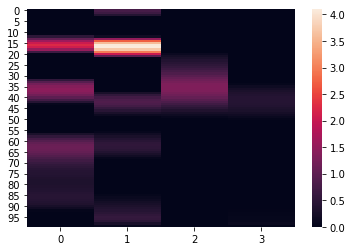

In [43]:
layer_name = "conv2d"
intermediate_layer_model = keras.Model(inputs = model.input,
                                 outputs=model.get_layer(layer_name).output)

intermediate_output = intermediate_layer_model.predict(num_data_with_wavelet)

res_to_show = intermediate_output[0,:,:,:]

fig = sns.heatmap(res_to_show[:,:,15])

plt.savefig("filter15.png")
print(np.shape(intermediate_output))

### Test on CNN

In [44]:
test_data_with_wavelet = np.zeros((18, 100, 4, 4))
for index_i_exp in range(18):
    for index_j_exp in range(4):
        test_data = sig.cwt(prediction_data[index_i_exp,:,index_j_exp], sig.ricker, widths = (3,5,7,10))  #shape = (5, 100)
        test_data_with_wavelet[index_i_exp, :, index_j_exp, :] = np.transpose(test_data)
        
test_data_with_wavelet = np.concatenate((prediction_data[:,:,:,np.newaxis], test_data_with_wavelet), axis = 3) 

In [45]:
prediction_cnn = model.predict(test_data_with_wavelet)
MAE(actual, prediction_cnn)

6.1143798828125

### CNN with 60% of input

In [46]:
num_data_with_wavelet_60 = np.zeros((976, 60, 4, 4))

for index_i_num in range(976):
    for index_j_num in range(4):
        num_data = sig.cwt(numerical_data[index_i_num,:60,index_j_num], sig.ricker, widths = (3, 5,7,10))  #shape = (5, 100)
        num_data_with_wavelet_60[index_i_num, :, index_j_num, :] = np.transpose(num_data)
num_data_with_wavelet_60 = np.concatenate((numerical_data[:,:60,:,np.newaxis], num_data_with_wavelet_60), axis = 3)

exp_data_with_wavelet_60 = np.zeros((24, 60, 4, 4))
for index_i_exp in range(24):
    for index_j_exp in range(4):
        exp_data = sig.cwt(experimental_data[index_i_exp,:60,index_j_exp], sig.ricker, widths = (3,5,7,10))  #shape = (5, 100)
        exp_data_with_wavelet_60[index_i_exp, :, index_j_exp, :] = np.transpose(exp_data)
        
exp_data_with_wavelet_60 = np.concatenate((experimental_data[:,:60,:,np.newaxis], exp_data_with_wavelet_60), axis = 3)        

In [47]:
inputs = keras.Input(shape=(60, 4, 5), name="input_layer")
x = layers.BatchNormalization()(inputs)
x1 = layers.Conv2D(16, kernel_size = (2,4), activation = "relu", kernel_regularizer = "l2", padding = "same")(x)
x2 = layers.BatchNormalization()(x1)
x3 = layers.Dropout(rate = 0.2)(x2)
x4 = layers.Conv2D(8, kernel_size = (4,1), activation = "relu", kernel_regularizer = "l2", padding = "same")(x3)
x5 = layers.BatchNormalization()(x4)
x6 = layers.Dropout(rate = 0.2)(x5)
x7 = layers.Conv2D(16, kernel_size = (8,1), activation = "relu", kernel_regularizer = "l2", padding = "same")(x6)
x8 = layers.Add()([x7, x1])
x9 = layers.Flatten()(x8)
x10 = layers.Dense(32, kernel_regularizer = "l2")(x9)
x11 = layers.BatchNormalization()(x10)
x12 = layers.Dropout(rate = 0.2)(x11)
x13 = layers.Dense(16, kernel_regularizer = "l2")(x12)
x14= layers.BatchNormalization()(x13)
x15 = layers.Dense(8, kernel_regularizer = "l2")(x14)
outputs = layers.Dense(2, kernel_regularizer = "l2")(x15)

In [48]:
model = keras.Model(inputs=inputs, outputs=outputs)

print(model.summary())

model.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # List of metrics to monitor
    metrics=[keras.metrics.MeanAbsoluteError()]
)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 60, 4, 5)]   0           []                               
                                                                                                  
 batch_normalization_20 (BatchN  (None, 60, 4, 5)    20          ['input_layer[0][0]']            
 ormalization)                                                                                    
                                                                                                  
 conv2d_3 (Conv2D)              (None, 60, 4, 16)    656         ['batch_normalization_20[0][0]'] 
                                                                                                  
 batch_normalization_21 (BatchN  (None, 60, 4, 16)   64          ['conv2d_3[0][0]']         

In [49]:
history = model.fit(
    num_data_with_wavelet_60,
    numerical_label,
    batch_size=40,
    epochs=600,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(exp_data_with_wavelet_60, experimental_label),shuffle = True
)

Epoch 1/600
25/25 [==============================] - 2s 31ms/step - loss: 64285.2500 - mean_absolute_error: 249.9227 - val_loss: 59310.2461 - val_mean_absolute_error: 242.7484
Epoch 2/600
25/25 [==============================] - 1s 22ms/step - loss: 64042.7617 - mean_absolute_error: 249.7165 - val_loss: 59069.9727 - val_mean_absolute_error: 242.3706
Epoch 3/600
25/25 [==============================] - 0s 19ms/step - loss: 63779.1133 - mean_absolute_error: 249.4043 - val_loss: 58615.3242 - val_mean_absolute_error: 241.4941
Epoch 4/600
25/25 [==============================] - 1s 20ms/step - loss: 63430.2734 - mean_absolute_error: 248.9290 - val_loss: 58834.0977 - val_mean_absolute_error: 241.9533
Epoch 5/600
25/25 [==============================] - 0s 19ms/step - loss: 62953.2539 - mean_absolute_error: 248.2254 - val_loss: 59355.1914 - val_mean_absolute_error: 242.9450
Epoch 6/600
25/25 [==============================] - 0s 19ms/step - loss: 62331.1328 - mean_absolute_error: 247.2151 - v

25/25 [==============================] - 1s 22ms/step - loss: 506.9127 - mean_absolute_error: 18.1986 - val_loss: 142.8579 - val_mean_absolute_error: 8.4712
Epoch 49/600
25/25 [==============================] - 1s 21ms/step - loss: 486.0438 - mean_absolute_error: 17.8686 - val_loss: 110.1180 - val_mean_absolute_error: 7.5072
Epoch 50/600
25/25 [==============================] - 1s 21ms/step - loss: 453.8105 - mean_absolute_error: 17.2443 - val_loss: 126.6345 - val_mean_absolute_error: 8.1021
Epoch 51/600
25/25 [==============================] - 1s 23ms/step - loss: 444.1059 - mean_absolute_error: 17.1047 - val_loss: 133.5242 - val_mean_absolute_error: 7.8283
Epoch 52/600
25/25 [==============================] - 1s 26ms/step - loss: 417.0500 - mean_absolute_error: 16.5972 - val_loss: 131.4164 - val_mean_absolute_error: 8.4066
Epoch 53/600
25/25 [==============================] - 1s 21ms/step - loss: 386.6087 - mean_absolute_error: 15.9589 - val_loss: 138.3862 - val_mean_absolute_error: 

25/25 [==============================] - 1s 21ms/step - loss: 105.2940 - mean_absolute_error: 7.9458 - val_loss: 110.7675 - val_mean_absolute_error: 8.5562
Epoch 97/600
25/25 [==============================] - 1s 21ms/step - loss: 111.8819 - mean_absolute_error: 8.3090 - val_loss: 112.9108 - val_mean_absolute_error: 8.7330
Epoch 98/600
25/25 [==============================] - 1s 20ms/step - loss: 108.0846 - mean_absolute_error: 7.9857 - val_loss: 100.5650 - val_mean_absolute_error: 8.4822
Epoch 99/600
25/25 [==============================] - 1s 20ms/step - loss: 103.8892 - mean_absolute_error: 7.9087 - val_loss: 157.2205 - val_mean_absolute_error: 9.9393
Epoch 100/600
25/25 [==============================] - 1s 20ms/step - loss: 114.2534 - mean_absolute_error: 8.3254 - val_loss: 131.0854 - val_mean_absolute_error: 9.0338
Epoch 101/600
25/25 [==============================] - 1s 20ms/step - loss: 132.3603 - mean_absolute_error: 8.9156 - val_loss: 95.5603 - val_mean_absolute_error: 7.682

25/25 [==============================] - 1s 21ms/step - loss: 98.7346 - mean_absolute_error: 7.6879 - val_loss: 104.6930 - val_mean_absolute_error: 8.5523
Epoch 145/600
25/25 [==============================] - 1s 21ms/step - loss: 108.2819 - mean_absolute_error: 7.8491 - val_loss: 103.8737 - val_mean_absolute_error: 8.4453
Epoch 146/600
25/25 [==============================] - 1s 21ms/step - loss: 112.6647 - mean_absolute_error: 8.2884 - val_loss: 101.3559 - val_mean_absolute_error: 8.1877
Epoch 147/600
25/25 [==============================] - 1s 21ms/step - loss: 91.8982 - mean_absolute_error: 7.3594 - val_loss: 84.0322 - val_mean_absolute_error: 7.5122
Epoch 148/600
25/25 [==============================] - 1s 21ms/step - loss: 101.3128 - mean_absolute_error: 7.7348 - val_loss: 123.6865 - val_mean_absolute_error: 8.9848
Epoch 149/600
25/25 [==============================] - 1s 21ms/step - loss: 87.2053 - mean_absolute_error: 7.2361 - val_loss: 121.6965 - val_mean_absolute_error: 9.282

25/25 [==============================] - 1s 21ms/step - loss: 99.6917 - mean_absolute_error: 7.7619 - val_loss: 96.5049 - val_mean_absolute_error: 8.0515
Epoch 193/600
25/25 [==============================] - 1s 20ms/step - loss: 97.5077 - mean_absolute_error: 7.6564 - val_loss: 107.3223 - val_mean_absolute_error: 8.5266
Epoch 194/600
25/25 [==============================] - 1s 20ms/step - loss: 100.0862 - mean_absolute_error: 7.8518 - val_loss: 106.2962 - val_mean_absolute_error: 8.1375
Epoch 195/600
25/25 [==============================] - 1s 20ms/step - loss: 101.6276 - mean_absolute_error: 7.7431 - val_loss: 99.1555 - val_mean_absolute_error: 8.2926
Epoch 196/600
25/25 [==============================] - 1s 20ms/step - loss: 91.6644 - mean_absolute_error: 7.2806 - val_loss: 100.5316 - val_mean_absolute_error: 8.0525
Epoch 197/600
25/25 [==============================] - 1s 20ms/step - loss: 104.5138 - mean_absolute_error: 7.7531 - val_loss: 98.9859 - val_mean_absolute_error: 7.8370


25/25 [==============================] - 1s 22ms/step - loss: 115.0749 - mean_absolute_error: 8.1023 - val_loss: 87.3029 - val_mean_absolute_error: 7.4204
Epoch 241/600
25/25 [==============================] - 1s 21ms/step - loss: 98.6351 - mean_absolute_error: 7.7687 - val_loss: 77.6555 - val_mean_absolute_error: 6.9599
Epoch 242/600
25/25 [==============================] - 1s 20ms/step - loss: 94.2032 - mean_absolute_error: 7.3431 - val_loss: 105.4947 - val_mean_absolute_error: 7.7594
Epoch 243/600
25/25 [==============================] - 1s 23ms/step - loss: 129.1362 - mean_absolute_error: 8.8162 - val_loss: 103.0087 - val_mean_absolute_error: 8.2619
Epoch 244/600
25/25 [==============================] - 1s 21ms/step - loss: 91.7538 - mean_absolute_error: 7.2656 - val_loss: 101.2946 - val_mean_absolute_error: 8.1722
Epoch 245/600
25/25 [==============================] - 1s 21ms/step - loss: 98.8798 - mean_absolute_error: 7.6608 - val_loss: 97.3433 - val_mean_absolute_error: 7.7440
E

25/25 [==============================] - 1s 21ms/step - loss: 81.3831 - mean_absolute_error: 6.8401 - val_loss: 94.6610 - val_mean_absolute_error: 7.8895
Epoch 289/600
25/25 [==============================] - 1s 20ms/step - loss: 90.7128 - mean_absolute_error: 7.2562 - val_loss: 98.2109 - val_mean_absolute_error: 7.8156
Epoch 290/600
25/25 [==============================] - 0s 20ms/step - loss: 104.5270 - mean_absolute_error: 7.8638 - val_loss: 93.9356 - val_mean_absolute_error: 7.8118
Epoch 291/600
25/25 [==============================] - 1s 20ms/step - loss: 102.8187 - mean_absolute_error: 7.8069 - val_loss: 80.1055 - val_mean_absolute_error: 7.2005
Epoch 292/600
25/25 [==============================] - 1s 21ms/step - loss: 103.3493 - mean_absolute_error: 7.9372 - val_loss: 87.4235 - val_mean_absolute_error: 7.4711
Epoch 293/600
25/25 [==============================] - 1s 21ms/step - loss: 103.1937 - mean_absolute_error: 8.0371 - val_loss: 85.7367 - val_mean_absolute_error: 7.3667
Ep

25/25 [==============================] - 1s 21ms/step - loss: 129.4290 - mean_absolute_error: 8.3236 - val_loss: 110.0198 - val_mean_absolute_error: 7.9342
Epoch 337/600
25/25 [==============================] - 1s 20ms/step - loss: 102.1770 - mean_absolute_error: 7.7870 - val_loss: 94.9773 - val_mean_absolute_error: 7.5750
Epoch 338/600
25/25 [==============================] - 1s 20ms/step - loss: 109.3744 - mean_absolute_error: 8.1103 - val_loss: 92.5793 - val_mean_absolute_error: 7.5778
Epoch 339/600
25/25 [==============================] - 1s 20ms/step - loss: 103.5972 - mean_absolute_error: 7.8834 - val_loss: 90.6876 - val_mean_absolute_error: 7.6600
Epoch 340/600
25/25 [==============================] - 1s 21ms/step - loss: 106.5017 - mean_absolute_error: 8.0905 - val_loss: 90.8727 - val_mean_absolute_error: 7.3433
Epoch 341/600
25/25 [==============================] - 1s 20ms/step - loss: 91.2066 - mean_absolute_error: 7.3534 - val_loss: 88.9738 - val_mean_absolute_error: 7.2864


25/25 [==============================] - 1s 20ms/step - loss: 99.7989 - mean_absolute_error: 7.7248 - val_loss: 86.2837 - val_mean_absolute_error: 7.4171
Epoch 385/600
25/25 [==============================] - 1s 20ms/step - loss: 101.7365 - mean_absolute_error: 7.7129 - val_loss: 81.0564 - val_mean_absolute_error: 7.2839
Epoch 386/600
25/25 [==============================] - 1s 21ms/step - loss: 114.0358 - mean_absolute_error: 8.3395 - val_loss: 68.8115 - val_mean_absolute_error: 6.8599
Epoch 387/600
25/25 [==============================] - 1s 20ms/step - loss: 113.3991 - mean_absolute_error: 8.3547 - val_loss: 94.1485 - val_mean_absolute_error: 7.8203
Epoch 388/600
25/25 [==============================] - 0s 20ms/step - loss: 121.5657 - mean_absolute_error: 8.6351 - val_loss: 80.9487 - val_mean_absolute_error: 7.3228
Epoch 389/600
25/25 [==============================] - 1s 20ms/step - loss: 91.5884 - mean_absolute_error: 7.3157 - val_loss: 77.0800 - val_mean_absolute_error: 6.8883
Ep

Epoch 433/600
25/25 [==============================] - 1s 20ms/step - loss: 120.9738 - mean_absolute_error: 8.5044 - val_loss: 53.5234 - val_mean_absolute_error: 6.0249
Epoch 434/600
25/25 [==============================] - 0s 20ms/step - loss: 95.2839 - mean_absolute_error: 7.6322 - val_loss: 80.8525 - val_mean_absolute_error: 7.3062
Epoch 435/600
25/25 [==============================] - 1s 20ms/step - loss: 102.3942 - mean_absolute_error: 7.7975 - val_loss: 58.1611 - val_mean_absolute_error: 6.2242
Epoch 436/600
25/25 [==============================] - 1s 20ms/step - loss: 122.9425 - mean_absolute_error: 8.5520 - val_loss: 80.6665 - val_mean_absolute_error: 7.2232
Epoch 437/600
25/25 [==============================] - 1s 20ms/step - loss: 99.7956 - mean_absolute_error: 7.8652 - val_loss: 71.7606 - val_mean_absolute_error: 6.7631
Epoch 438/600
25/25 [==============================] - 0s 20ms/step - loss: 92.6948 - mean_absolute_error: 7.3710 - val_loss: 86.3661 - val_mean_absolute_err

25/25 [==============================] - 1s 20ms/step - loss: 100.3187 - mean_absolute_error: 7.6126 - val_loss: 75.7339 - val_mean_absolute_error: 7.0497
Epoch 482/600
25/25 [==============================] - 1s 20ms/step - loss: 137.1349 - mean_absolute_error: 9.3930 - val_loss: 81.4142 - val_mean_absolute_error: 7.2108
Epoch 483/600
25/25 [==============================] - 1s 20ms/step - loss: 97.5312 - mean_absolute_error: 7.6690 - val_loss: 74.8643 - val_mean_absolute_error: 6.9104
Epoch 484/600
25/25 [==============================] - 1s 21ms/step - loss: 98.3006 - mean_absolute_error: 7.5195 - val_loss: 63.8537 - val_mean_absolute_error: 6.2184
Epoch 485/600
25/25 [==============================] - 1s 20ms/step - loss: 113.6029 - mean_absolute_error: 8.3069 - val_loss: 65.3371 - val_mean_absolute_error: 6.4575
Epoch 486/600
25/25 [==============================] - 1s 20ms/step - loss: 91.6723 - mean_absolute_error: 7.3030 - val_loss: 72.0421 - val_mean_absolute_error: 6.8713
Epo

Epoch 530/600
25/25 [==============================] - 1s 20ms/step - loss: 96.6815 - mean_absolute_error: 7.4586 - val_loss: 55.8634 - val_mean_absolute_error: 5.9921
Epoch 531/600
25/25 [==============================] - 1s 21ms/step - loss: 109.9835 - mean_absolute_error: 7.9690 - val_loss: 74.2206 - val_mean_absolute_error: 6.8611
Epoch 532/600
25/25 [==============================] - 1s 20ms/step - loss: 83.5767 - mean_absolute_error: 6.9536 - val_loss: 76.1213 - val_mean_absolute_error: 6.8419
Epoch 533/600
25/25 [==============================] - 1s 20ms/step - loss: 110.5680 - mean_absolute_error: 8.1759 - val_loss: 58.4214 - val_mean_absolute_error: 5.6179
Epoch 534/600
25/25 [==============================] - 1s 20ms/step - loss: 93.3304 - mean_absolute_error: 7.5119 - val_loss: 59.5981 - val_mean_absolute_error: 6.1014
Epoch 535/600
25/25 [==============================] - 1s 21ms/step - loss: 100.4078 - mean_absolute_error: 7.7648 - val_loss: 55.6682 - val_mean_absolute_err

25/25 [==============================] - 1s 21ms/step - loss: 103.2930 - mean_absolute_error: 7.7880 - val_loss: 63.1944 - val_mean_absolute_error: 6.1904
Epoch 579/600
25/25 [==============================] - 1s 20ms/step - loss: 85.2714 - mean_absolute_error: 7.0864 - val_loss: 58.4144 - val_mean_absolute_error: 6.0190
Epoch 580/600
25/25 [==============================] - 1s 20ms/step - loss: 110.8418 - mean_absolute_error: 8.1269 - val_loss: 63.4446 - val_mean_absolute_error: 6.4007
Epoch 581/600
25/25 [==============================] - 1s 20ms/step - loss: 110.4446 - mean_absolute_error: 8.0931 - val_loss: 57.8968 - val_mean_absolute_error: 5.9442
Epoch 582/600
25/25 [==============================] - 1s 20ms/step - loss: 92.7209 - mean_absolute_error: 7.3697 - val_loss: 52.6730 - val_mean_absolute_error: 5.4769
Epoch 583/600
25/25 [==============================] - 0s 20ms/step - loss: 106.5823 - mean_absolute_error: 8.0962 - val_loss: 65.6833 - val_mean_absolute_error: 6.1931
Ep

### Test on CNN with 60% of input

In [50]:
test_data_with_wavelet_60 = np.zeros((18, 60, 4, 4))
for index_i_exp in range(18):
    for index_j_exp in range(4):
        test_data = sig.cwt(prediction_data[index_i_exp,:60,index_j_exp], sig.ricker, widths = (3,5,7,10))  #shape = (5, 100)
        test_data_with_wavelet_60[index_i_exp, :, index_j_exp, :] = np.transpose(test_data)
        
test_data_with_wavelet_60 = np.concatenate((prediction_data[:,:60,:,np.newaxis], test_data_with_wavelet_60), axis = 3) 

In [51]:
prediction_cnn_60 = model.predict(test_data_with_wavelet_60)
MAE(actual, prediction_cnn_60)

7.075148264567058

## CNN-GRU

In [52]:
inputs = keras.Input(shape=(100, 4, 5), name="input_layer")
x = layers.BatchNormalization()(inputs)
x1 = layers.Conv2D(16, kernel_size = (2,4), activation = "relu", kernel_regularizer = "l2", padding = "same")(x)
x2 = layers.BatchNormalization()(x1)
x3 = layers.Dropout(rate = 0.2)(x2)
x4 = layers.Conv2D(8, kernel_size = (4,1), activation = "relu", kernel_regularizer = "l2", padding = "same")(x3)
x5 = layers.BatchNormalization()(x4)
x6 = layers.Dropout(rate = 0.2)(x5)
x7 = layers.Conv2D(16, kernel_size = (8,1), activation = "relu", kernel_regularizer = "l2", padding = "same")(x6)
x8 = layers.Add()([x7, x1])
x9 = layers.Conv2D(1, kernel_size = (2,4), activation = "relu", kernel_regularizer = "l2", padding = "same")(x8)
# LSTM model
x10 = layers.Reshape((100, 4))(x9)
# x10 = layers.LayerNormalization(x10 )
x11 = layers.LayerNormalization()(x10)
x12 = layers.GRU(units = 32, input_shape = (100,4), activation = "relu", kernel_regularizer = "l2", return_sequences = False)(x11)
x13 = layers.Flatten()(x12)
x14 = layers.BatchNormalization()(x13)
x15 = layers.Dense(16, kernel_regularizer = "l2")(x14)
x16 = layers.BatchNormalization()(x15)
x17 = layers.Dense(8, kernel_regularizer = "l2")(x16)
outputs = layers.Dense(2, kernel_regularizer = "l2")(x17)

In [53]:
model = keras.Model(inputs=inputs, outputs=outputs)

print(model.summary())

model.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # List of metrics to monitor
    metrics=[keras.metrics.MeanAbsoluteError()]
)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 100, 4, 5)]  0           []                               
                                                                                                  
 batch_normalization_25 (BatchN  (None, 100, 4, 5)   20          ['input_layer[0][0]']            
 ormalization)                                                                                    
                                                                                                  
 conv2d_6 (Conv2D)              (None, 100, 4, 16)   656         ['batch_normalization_25[0][0]'] 
                                                                                                  
 batch_normalization_26 (BatchN  (None, 100, 4, 16)  64          ['conv2d_6[0][0]']         

In [54]:
history = model.fit(
    num_data_with_wavelet,
    numerical_label,
    batch_size=40,
    epochs=600,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(exp_data_with_wavelet, experimental_label),shuffle = True
)

Epoch 1/600
25/25 [==============================] - 4s 91ms/step - loss: 64481.4062 - mean_absolute_error: 249.9452 - val_loss: 57218.1836 - val_mean_absolute_error: 237.7380
Epoch 2/600
25/25 [==============================] - 2s 68ms/step - loss: 64392.7500 - mean_absolute_error: 249.8007 - val_loss: 57156.3008 - val_mean_absolute_error: 237.6038
Epoch 3/600
25/25 [==============================] - 2s 69ms/step - loss: 64231.3008 - mean_absolute_error: 249.5668 - val_loss: 57123.5820 - val_mean_absolute_error: 237.5193
Epoch 4/600
25/25 [==============================] - 2s 69ms/step - loss: 63950.3125 - mean_absolute_error: 249.1669 - val_loss: 57344.3281 - val_mean_absolute_error: 237.9758
Epoch 5/600
25/25 [==============================] - 2s 72ms/step - loss: 63491.7969 - mean_absolute_error: 248.5078 - val_loss: 57494.3750 - val_mean_absolute_error: 238.2722
Epoch 6/600
25/25 [==============================] - 2s 71ms/step - loss: 62855.9336 - mean_absolute_error: 247.5047 - v

25/25 [==============================] - 2s 70ms/step - loss: 117.7825 - mean_absolute_error: 8.5970 - val_loss: 131.9212 - val_mean_absolute_error: 8.4216
Epoch 49/600
25/25 [==============================] - 2s 71ms/step - loss: 130.2466 - mean_absolute_error: 8.9482 - val_loss: 112.3592 - val_mean_absolute_error: 8.4887
Epoch 50/600
25/25 [==============================] - 2s 70ms/step - loss: 121.5468 - mean_absolute_error: 8.6297 - val_loss: 85.4170 - val_mean_absolute_error: 6.8981
Epoch 51/600
25/25 [==============================] - 2s 70ms/step - loss: 109.1258 - mean_absolute_error: 8.1511 - val_loss: 90.5907 - val_mean_absolute_error: 7.3716
Epoch 52/600
25/25 [==============================] - 2s 71ms/step - loss: 111.2061 - mean_absolute_error: 8.2800 - val_loss: 101.0040 - val_mean_absolute_error: 7.8926
Epoch 53/600
25/25 [==============================] - 2s 70ms/step - loss: 104.9218 - mean_absolute_error: 8.1941 - val_loss: 87.6405 - val_mean_absolute_error: 7.0543
Ep

Epoch 97/600
25/25 [==============================] - 2s 71ms/step - loss: 87.5772 - mean_absolute_error: 7.2197 - val_loss: 58.5150 - val_mean_absolute_error: 6.1627
Epoch 98/600
25/25 [==============================] - 2s 71ms/step - loss: 69.4082 - mean_absolute_error: 6.4734 - val_loss: 59.7865 - val_mean_absolute_error: 5.8349
Epoch 99/600
25/25 [==============================] - 2s 69ms/step - loss: 78.2778 - mean_absolute_error: 6.8953 - val_loss: 96.7962 - val_mean_absolute_error: 8.2634
Epoch 100/600
25/25 [==============================] - 2s 70ms/step - loss: 69.5078 - mean_absolute_error: 6.3079 - val_loss: 66.4580 - val_mean_absolute_error: 6.7048
Epoch 101/600
25/25 [==============================] - 2s 70ms/step - loss: 68.9410 - mean_absolute_error: 6.5765 - val_loss: 92.2307 - val_mean_absolute_error: 7.8239
Epoch 102/600
25/25 [==============================] - 2s 70ms/step - loss: 84.8435 - mean_absolute_error: 7.1514 - val_loss: 67.2770 - val_mean_absolute_error: 6.

Epoch 146/600
25/25 [==============================] - 2s 71ms/step - loss: 72.8773 - mean_absolute_error: 6.5071 - val_loss: 56.8847 - val_mean_absolute_error: 6.3519
Epoch 147/600
25/25 [==============================] - 2s 70ms/step - loss: 77.7728 - mean_absolute_error: 6.9845 - val_loss: 66.2217 - val_mean_absolute_error: 6.4163
Epoch 148/600
25/25 [==============================] - 2s 71ms/step - loss: 83.4519 - mean_absolute_error: 7.2511 - val_loss: 58.7968 - val_mean_absolute_error: 6.4280
Epoch 149/600
25/25 [==============================] - 2s 70ms/step - loss: 60.4105 - mean_absolute_error: 6.1287 - val_loss: 53.2491 - val_mean_absolute_error: 5.9734
Epoch 150/600
25/25 [==============================] - 2s 71ms/step - loss: 89.5148 - mean_absolute_error: 7.6035 - val_loss: 43.4069 - val_mean_absolute_error: 5.2070
Epoch 151/600
25/25 [==============================] - 2s 70ms/step - loss: 77.0449 - mean_absolute_error: 6.9201 - val_loss: 42.5390 - val_mean_absolute_error:

Epoch 195/600
25/25 [==============================] - 2s 70ms/step - loss: 68.2147 - mean_absolute_error: 6.3935 - val_loss: 43.8110 - val_mean_absolute_error: 5.5673
Epoch 196/600
25/25 [==============================] - 2s 70ms/step - loss: 99.7698 - mean_absolute_error: 7.5165 - val_loss: 45.5874 - val_mean_absolute_error: 5.7489
Epoch 197/600
25/25 [==============================] - 2s 72ms/step - loss: 94.9198 - mean_absolute_error: 7.6810 - val_loss: 35.2578 - val_mean_absolute_error: 4.7687
Epoch 198/600
25/25 [==============================] - 2s 71ms/step - loss: 78.6024 - mean_absolute_error: 6.9845 - val_loss: 45.8115 - val_mean_absolute_error: 5.2877
Epoch 199/600
25/25 [==============================] - 2s 71ms/step - loss: 76.1922 - mean_absolute_error: 6.8576 - val_loss: 26.6194 - val_mean_absolute_error: 4.0530
Epoch 200/600
25/25 [==============================] - 2s 70ms/step - loss: 91.9114 - mean_absolute_error: 7.4086 - val_loss: 33.3846 - val_mean_absolute_error:

Epoch 244/600
25/25 [==============================] - 2s 82ms/step - loss: 66.9662 - mean_absolute_error: 6.1949 - val_loss: 48.3073 - val_mean_absolute_error: 5.2052
Epoch 245/600
25/25 [==============================] - 2s 75ms/step - loss: 63.3275 - mean_absolute_error: 6.0741 - val_loss: 44.8025 - val_mean_absolute_error: 5.3623
Epoch 246/600
25/25 [==============================] - 2s 80ms/step - loss: 79.6204 - mean_absolute_error: 7.1632 - val_loss: 31.8967 - val_mean_absolute_error: 4.5916
Epoch 247/600
25/25 [==============================] - 2s 79ms/step - loss: 77.8626 - mean_absolute_error: 6.9789 - val_loss: 28.9310 - val_mean_absolute_error: 4.4364
Epoch 248/600
25/25 [==============================] - 2s 74ms/step - loss: 51.8787 - mean_absolute_error: 5.6127 - val_loss: 48.5149 - val_mean_absolute_error: 5.7828
Epoch 249/600
25/25 [==============================] - 2s 72ms/step - loss: 84.0612 - mean_absolute_error: 7.2641 - val_loss: 42.5378 - val_mean_absolute_error:

Epoch 293/600
25/25 [==============================] - 2s 86ms/step - loss: 102.6065 - mean_absolute_error: 8.1581 - val_loss: 52.0585 - val_mean_absolute_error: 5.1362
Epoch 294/600
25/25 [==============================] - 2s 79ms/step - loss: 80.2494 - mean_absolute_error: 7.1598 - val_loss: 49.1806 - val_mean_absolute_error: 5.8080
Epoch 295/600
25/25 [==============================] - 2s 79ms/step - loss: 52.9091 - mean_absolute_error: 5.6640 - val_loss: 51.6081 - val_mean_absolute_error: 5.8802
Epoch 296/600
25/25 [==============================] - 2s 80ms/step - loss: 73.0780 - mean_absolute_error: 6.5360 - val_loss: 55.1744 - val_mean_absolute_error: 5.8974
Epoch 297/600
25/25 [==============================] - 2s 86ms/step - loss: 68.2286 - mean_absolute_error: 6.5609 - val_loss: 60.1680 - val_mean_absolute_error: 6.4405
Epoch 298/600
25/25 [==============================] - 2s 90ms/step - loss: 78.0511 - mean_absolute_error: 6.8590 - val_loss: 36.3895 - val_mean_absolute_error

Epoch 342/600
25/25 [==============================] - 2s 76ms/step - loss: 73.1304 - mean_absolute_error: 6.8092 - val_loss: 56.5833 - val_mean_absolute_error: 5.9436
Epoch 343/600
25/25 [==============================] - 2s 82ms/step - loss: 58.1062 - mean_absolute_error: 6.0159 - val_loss: 50.0942 - val_mean_absolute_error: 5.2088
Epoch 344/600
25/25 [==============================] - 2s 76ms/step - loss: 77.7830 - mean_absolute_error: 6.8083 - val_loss: 48.4150 - val_mean_absolute_error: 5.7139
Epoch 345/600
25/25 [==============================] - 2s 77ms/step - loss: 57.7285 - mean_absolute_error: 5.7617 - val_loss: 49.4607 - val_mean_absolute_error: 5.6567
Epoch 346/600
25/25 [==============================] - 2s 75ms/step - loss: 80.1337 - mean_absolute_error: 7.3013 - val_loss: 60.4280 - val_mean_absolute_error: 6.0176
Epoch 347/600
25/25 [==============================] - 2s 76ms/step - loss: 87.8291 - mean_absolute_error: 7.4647 - val_loss: 64.3007 - val_mean_absolute_error:

Epoch 391/600
25/25 [==============================] - 2s 78ms/step - loss: 76.7026 - mean_absolute_error: 6.9191 - val_loss: 46.4843 - val_mean_absolute_error: 4.7923
Epoch 392/600
25/25 [==============================] - 2s 80ms/step - loss: 58.0925 - mean_absolute_error: 6.0665 - val_loss: 54.7861 - val_mean_absolute_error: 5.6164
Epoch 393/600
25/25 [==============================] - 2s 77ms/step - loss: 63.0070 - mean_absolute_error: 6.0481 - val_loss: 45.6208 - val_mean_absolute_error: 5.2182
Epoch 394/600
25/25 [==============================] - 2s 75ms/step - loss: 65.2146 - mean_absolute_error: 6.2448 - val_loss: 56.6929 - val_mean_absolute_error: 5.7340
Epoch 395/600
25/25 [==============================] - 2s 74ms/step - loss: 79.8575 - mean_absolute_error: 6.7336 - val_loss: 44.8890 - val_mean_absolute_error: 4.9112
Epoch 396/600
25/25 [==============================] - 2s 75ms/step - loss: 60.8130 - mean_absolute_error: 6.0418 - val_loss: 52.3736 - val_mean_absolute_error:

Epoch 440/600
25/25 [==============================] - 2s 71ms/step - loss: 67.2617 - mean_absolute_error: 6.4375 - val_loss: 61.7828 - val_mean_absolute_error: 5.5215
Epoch 441/600
25/25 [==============================] - 2s 70ms/step - loss: 69.4677 - mean_absolute_error: 6.5509 - val_loss: 69.5101 - val_mean_absolute_error: 6.8540
Epoch 442/600
25/25 [==============================] - 2s 70ms/step - loss: 55.6892 - mean_absolute_error: 5.7433 - val_loss: 75.7507 - val_mean_absolute_error: 6.9229
Epoch 443/600
25/25 [==============================] - 2s 70ms/step - loss: 71.2840 - mean_absolute_error: 6.6187 - val_loss: 62.5609 - val_mean_absolute_error: 5.6445
Epoch 444/600
25/25 [==============================] - 2s 72ms/step - loss: 62.7309 - mean_absolute_error: 6.2406 - val_loss: 45.2106 - val_mean_absolute_error: 5.0688
Epoch 445/600
25/25 [==============================] - 2s 75ms/step - loss: 68.5158 - mean_absolute_error: 6.3962 - val_loss: 52.6567 - val_mean_absolute_error:

Epoch 489/600
25/25 [==============================] - 2s 72ms/step - loss: 45.9786 - mean_absolute_error: 5.1933 - val_loss: 64.4339 - val_mean_absolute_error: 6.2492
Epoch 490/600
25/25 [==============================] - 2s 71ms/step - loss: 70.6858 - mean_absolute_error: 6.2315 - val_loss: 80.5642 - val_mean_absolute_error: 7.1089
Epoch 491/600
25/25 [==============================] - 2s 70ms/step - loss: 76.5958 - mean_absolute_error: 6.8176 - val_loss: 59.2848 - val_mean_absolute_error: 6.1456
Epoch 492/600
25/25 [==============================] - 2s 71ms/step - loss: 73.0698 - mean_absolute_error: 6.5882 - val_loss: 69.8198 - val_mean_absolute_error: 5.8819
Epoch 493/600
25/25 [==============================] - 2s 71ms/step - loss: 65.1919 - mean_absolute_error: 6.3196 - val_loss: 53.0879 - val_mean_absolute_error: 5.6397
Epoch 494/600
25/25 [==============================] - 2s 72ms/step - loss: 54.1201 - mean_absolute_error: 5.9179 - val_loss: 83.8435 - val_mean_absolute_error:

Epoch 538/600
25/25 [==============================] - 2s 71ms/step - loss: 62.1421 - mean_absolute_error: 6.2454 - val_loss: 70.3642 - val_mean_absolute_error: 6.6415
Epoch 539/600
25/25 [==============================] - 2s 71ms/step - loss: 47.9581 - mean_absolute_error: 5.2583 - val_loss: 69.8621 - val_mean_absolute_error: 6.5087
Epoch 540/600
25/25 [==============================] - 2s 70ms/step - loss: 63.2791 - mean_absolute_error: 6.0983 - val_loss: 56.1019 - val_mean_absolute_error: 5.3495
Epoch 541/600
25/25 [==============================] - 2s 70ms/step - loss: 66.7833 - mean_absolute_error: 6.0146 - val_loss: 58.2541 - val_mean_absolute_error: 5.3022
Epoch 542/600
25/25 [==============================] - 2s 70ms/step - loss: 61.0680 - mean_absolute_error: 6.0349 - val_loss: 60.8601 - val_mean_absolute_error: 5.7976
Epoch 543/600
25/25 [==============================] - 2s 70ms/step - loss: 94.9148 - mean_absolute_error: 7.6233 - val_loss: 62.8785 - val_mean_absolute_error:

Epoch 587/600
25/25 [==============================] - 2s 71ms/step - loss: 64.3888 - mean_absolute_error: 6.3809 - val_loss: 63.1454 - val_mean_absolute_error: 5.8241
Epoch 588/600
25/25 [==============================] - 2s 71ms/step - loss: 58.8666 - mean_absolute_error: 5.8109 - val_loss: 59.7476 - val_mean_absolute_error: 5.2342
Epoch 589/600
25/25 [==============================] - 2s 71ms/step - loss: 61.2044 - mean_absolute_error: 6.1259 - val_loss: 55.6036 - val_mean_absolute_error: 5.5609
Epoch 590/600
25/25 [==============================] - 2s 71ms/step - loss: 81.9254 - mean_absolute_error: 7.1937 - val_loss: 68.0689 - val_mean_absolute_error: 6.6039
Epoch 591/600
25/25 [==============================] - 2s 72ms/step - loss: 77.1180 - mean_absolute_error: 6.8572 - val_loss: 55.3855 - val_mean_absolute_error: 5.9233
Epoch 592/600
25/25 [==============================] - 2s 71ms/step - loss: 62.1573 - mean_absolute_error: 6.2021 - val_loss: 80.3034 - val_mean_absolute_error:

### Test on CNN-GRU

In [55]:
prediction_cnn_gru = model.predict(test_data_with_wavelet)
MAE(actual, prediction_cnn_gru)

5.695975833468967

## CNN-GRU with 60% of input

In [56]:
inputs = keras.Input(shape=(60, 4, 5), name="input_layer")
x = layers.BatchNormalization()(inputs)
x1 = layers.Conv2D(16, kernel_size = (2,4), activation = "relu", kernel_regularizer = "l2", padding = "same")(x)
x2 = layers.BatchNormalization()(x1)
x3 = layers.Dropout(rate = 0.2)(x2)
x4 = layers.Conv2D(8, kernel_size = (4,1), activation = "relu", kernel_regularizer = "l2", padding = "same")(x3)
x5 = layers.BatchNormalization()(x4)
x6 = layers.Dropout(rate = 0.2)(x5)
x7 = layers.Conv2D(16, kernel_size = (8,1), activation = "relu", kernel_regularizer = "l2", padding = "same")(x6)
x8 = layers.Add()([x7, x1])
x9 = layers.Conv2D(1, kernel_size = (2,4), activation = "relu", kernel_regularizer = "l2", padding = "same")(x8)
x10 = layers.Reshape((60, 4))(x9)
x11 = layers.LayerNormalization()(x10)
# changed reshape size
x12 = layers.GRU(units = 32, input_shape = (60,4), activation = "relu", kernel_regularizer = "l2", return_sequences = False)(x11)
x13 = layers.Flatten()(x12)
x14 = layers.BatchNormalization()(x13)
x15 = layers.Dense(16, kernel_regularizer = "l2")(x14)
x16 = layers.BatchNormalization()(x15)
x17 = layers.Dense(8, kernel_regularizer = "l2")(x16)
outputs = layers.Dense(2, kernel_regularizer = "l2")(x17)

In [57]:
model = keras.Model(inputs=inputs, outputs=outputs)

print(model.summary())

model.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # List of metrics to monitor
    metrics=[keras.metrics.MeanAbsoluteError()]
)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 60, 4, 5)]   0           []                               
                                                                                                  
 batch_normalization_30 (BatchN  (None, 60, 4, 5)    20          ['input_layer[0][0]']            
 ormalization)                                                                                    
                                                                                                  
 conv2d_10 (Conv2D)             (None, 60, 4, 16)    656         ['batch_normalization_30[0][0]'] 
                                                                                                  
 batch_normalization_31 (BatchN  (None, 60, 4, 16)   64          ['conv2d_10[0][0]']        

In [58]:
history = model.fit(
    num_data_with_wavelet_60,
    numerical_label,
    batch_size=40,
    epochs=600,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(exp_data_with_wavelet_60, experimental_label),shuffle = True
)

Epoch 1/600
25/25 [==============================] - 4s 59ms/step - loss: 64448.9258 - mean_absolute_error: 249.8963 - val_loss: 57154.9961 - val_mean_absolute_error: 237.6075
Epoch 2/600
25/25 [==============================] - 1s 44ms/step - loss: 64281.5547 - mean_absolute_error: 249.6333 - val_loss: 56980.0781 - val_mean_absolute_error: 237.2451
Epoch 3/600
25/25 [==============================] - 1s 44ms/step - loss: 64027.4414 - mean_absolute_error: 249.2466 - val_loss: 56769.3438 - val_mean_absolute_error: 236.8141
Epoch 4/600
25/25 [==============================] - 1s 44ms/step - loss: 63681.6758 - mean_absolute_error: 248.6630 - val_loss: 56395.9805 - val_mean_absolute_error: 236.0648
Epoch 5/600
25/25 [==============================] - 1s 44ms/step - loss: 63173.8008 - mean_absolute_error: 247.8129 - val_loss: 55728.3281 - val_mean_absolute_error: 234.7914
Epoch 6/600
25/25 [==============================] - 1s 44ms/step - loss: 62466.5117 - mean_absolute_error: 246.6137 - v

25/25 [==============================] - 1s 43ms/step - loss: 205.0340 - mean_absolute_error: 11.5362 - val_loss: 104.9126 - val_mean_absolute_error: 7.9814
Epoch 49/600
25/25 [==============================] - 1s 45ms/step - loss: 190.2829 - mean_absolute_error: 10.9736 - val_loss: 137.9959 - val_mean_absolute_error: 8.8098
Epoch 50/600
25/25 [==============================] - 1s 45ms/step - loss: 182.1034 - mean_absolute_error: 10.6779 - val_loss: 102.6710 - val_mean_absolute_error: 7.9578
Epoch 51/600
25/25 [==============================] - 1s 43ms/step - loss: 185.5583 - mean_absolute_error: 10.9208 - val_loss: 120.8077 - val_mean_absolute_error: 9.1141
Epoch 52/600
25/25 [==============================] - 1s 44ms/step - loss: 159.7855 - mean_absolute_error: 10.0532 - val_loss: 113.1619 - val_mean_absolute_error: 8.2535
Epoch 53/600
25/25 [==============================] - 1s 45ms/step - loss: 134.6921 - mean_absolute_error: 9.2637 - val_loss: 125.5707 - val_mean_absolute_error: 8

Epoch 97/600
25/25 [==============================] - 1s 44ms/step - loss: 81.9232 - mean_absolute_error: 7.1154 - val_loss: 161.3597 - val_mean_absolute_error: 8.8846
Epoch 98/600
25/25 [==============================] - 1s 44ms/step - loss: 80.6884 - mean_absolute_error: 7.0791 - val_loss: 121.1222 - val_mean_absolute_error: 8.0692
Epoch 99/600
25/25 [==============================] - 1s 45ms/step - loss: 72.8813 - mean_absolute_error: 6.8317 - val_loss: 117.9022 - val_mean_absolute_error: 8.2438
Epoch 100/600
25/25 [==============================] - 1s 44ms/step - loss: 72.6770 - mean_absolute_error: 6.4911 - val_loss: 105.3042 - val_mean_absolute_error: 7.7038
Epoch 101/600
25/25 [==============================] - 1s 44ms/step - loss: 78.7235 - mean_absolute_error: 6.9076 - val_loss: 130.2152 - val_mean_absolute_error: 8.6961
Epoch 102/600
25/25 [==============================] - 1s 44ms/step - loss: 100.6716 - mean_absolute_error: 7.8255 - val_loss: 107.0002 - val_mean_absolute_er

Epoch 146/600
25/25 [==============================] - 1s 45ms/step - loss: 80.0104 - mean_absolute_error: 7.1719 - val_loss: 65.6268 - val_mean_absolute_error: 6.0034
Epoch 147/600
25/25 [==============================] - 1s 45ms/step - loss: 54.4655 - mean_absolute_error: 5.6021 - val_loss: 79.5763 - val_mean_absolute_error: 6.6061
Epoch 148/600
25/25 [==============================] - 1s 44ms/step - loss: 72.0911 - mean_absolute_error: 6.4738 - val_loss: 70.3264 - val_mean_absolute_error: 6.4385
Epoch 149/600
25/25 [==============================] - 1s 44ms/step - loss: 58.9771 - mean_absolute_error: 6.0072 - val_loss: 72.2029 - val_mean_absolute_error: 6.2222
Epoch 150/600
25/25 [==============================] - 1s 45ms/step - loss: 79.6756 - mean_absolute_error: 6.8046 - val_loss: 93.8981 - val_mean_absolute_error: 7.1462
Epoch 151/600
25/25 [==============================] - 1s 45ms/step - loss: 89.7530 - mean_absolute_error: 7.3318 - val_loss: 57.5219 - val_mean_absolute_error:

Epoch 195/600
25/25 [==============================] - 1s 44ms/step - loss: 87.4478 - mean_absolute_error: 7.3524 - val_loss: 66.6159 - val_mean_absolute_error: 6.2568
Epoch 196/600
25/25 [==============================] - 1s 44ms/step - loss: 67.3394 - mean_absolute_error: 6.5744 - val_loss: 64.6880 - val_mean_absolute_error: 6.2446
Epoch 197/600
25/25 [==============================] - 1s 46ms/step - loss: 86.2417 - mean_absolute_error: 7.4650 - val_loss: 73.9392 - val_mean_absolute_error: 6.4080
Epoch 198/600
25/25 [==============================] - 1s 45ms/step - loss: 78.5288 - mean_absolute_error: 6.9313 - val_loss: 79.4112 - val_mean_absolute_error: 6.7985
Epoch 199/600
25/25 [==============================] - 1s 44ms/step - loss: 72.3481 - mean_absolute_error: 6.6848 - val_loss: 81.9719 - val_mean_absolute_error: 6.8152
Epoch 200/600
25/25 [==============================] - 1s 46ms/step - loss: 79.9297 - mean_absolute_error: 7.0180 - val_loss: 64.3620 - val_mean_absolute_error:

Epoch 244/600
25/25 [==============================] - 1s 47ms/step - loss: 82.2783 - mean_absolute_error: 7.0846 - val_loss: 80.9041 - val_mean_absolute_error: 6.9536
Epoch 245/600
25/25 [==============================] - 1s 46ms/step - loss: 71.7244 - mean_absolute_error: 6.4218 - val_loss: 80.9944 - val_mean_absolute_error: 6.8441
Epoch 246/600
25/25 [==============================] - 1s 46ms/step - loss: 66.8574 - mean_absolute_error: 6.3139 - val_loss: 73.8714 - val_mean_absolute_error: 6.2462
Epoch 247/600
25/25 [==============================] - 1s 46ms/step - loss: 53.8372 - mean_absolute_error: 5.8292 - val_loss: 91.1582 - val_mean_absolute_error: 7.4901
Epoch 248/600
25/25 [==============================] - 1s 45ms/step - loss: 64.7108 - mean_absolute_error: 6.2076 - val_loss: 71.2366 - val_mean_absolute_error: 6.5139
Epoch 249/600
25/25 [==============================] - 1s 46ms/step - loss: 61.9287 - mean_absolute_error: 6.1076 - val_loss: 78.3963 - val_mean_absolute_error:

Epoch 293/600
25/25 [==============================] - 1s 47ms/step - loss: 92.3830 - mean_absolute_error: 7.8153 - val_loss: 71.3653 - val_mean_absolute_error: 6.3251
Epoch 294/600
25/25 [==============================] - 1s 48ms/step - loss: 72.0062 - mean_absolute_error: 6.6977 - val_loss: 70.3960 - val_mean_absolute_error: 6.3367
Epoch 295/600
25/25 [==============================] - 1s 49ms/step - loss: 61.9123 - mean_absolute_error: 5.9211 - val_loss: 67.8492 - val_mean_absolute_error: 6.2585
Epoch 296/600
25/25 [==============================] - 1s 48ms/step - loss: 72.6288 - mean_absolute_error: 6.6966 - val_loss: 66.9649 - val_mean_absolute_error: 6.3341
Epoch 297/600
25/25 [==============================] - 1s 46ms/step - loss: 69.8455 - mean_absolute_error: 6.5505 - val_loss: 87.4459 - val_mean_absolute_error: 6.9257
Epoch 298/600
25/25 [==============================] - 1s 45ms/step - loss: 65.5861 - mean_absolute_error: 6.2050 - val_loss: 85.9919 - val_mean_absolute_error:

Epoch 342/600
25/25 [==============================] - 1s 47ms/step - loss: 73.4290 - mean_absolute_error: 6.8587 - val_loss: 73.8852 - val_mean_absolute_error: 6.7750
Epoch 343/600
25/25 [==============================] - 1s 48ms/step - loss: 60.2475 - mean_absolute_error: 5.9128 - val_loss: 117.7862 - val_mean_absolute_error: 8.2682
Epoch 344/600
25/25 [==============================] - 1s 49ms/step - loss: 75.1441 - mean_absolute_error: 6.6323 - val_loss: 106.9535 - val_mean_absolute_error: 7.9707
Epoch 345/600
25/25 [==============================] - 1s 49ms/step - loss: 81.1004 - mean_absolute_error: 6.7391 - val_loss: 70.2096 - val_mean_absolute_error: 6.0928
Epoch 346/600
25/25 [==============================] - 1s 47ms/step - loss: 62.3262 - mean_absolute_error: 6.2244 - val_loss: 101.4933 - val_mean_absolute_error: 7.1506
Epoch 347/600
25/25 [==============================] - 1s 48ms/step - loss: 61.9724 - mean_absolute_error: 6.2512 - val_loss: 153.1406 - val_mean_absolute_er

Epoch 391/600
25/25 [==============================] - 1s 45ms/step - loss: 74.0261 - mean_absolute_error: 7.0147 - val_loss: 98.4424 - val_mean_absolute_error: 6.9649
Epoch 392/600
25/25 [==============================] - 1s 45ms/step - loss: 66.6489 - mean_absolute_error: 6.5430 - val_loss: 68.2024 - val_mean_absolute_error: 6.0213
Epoch 393/600
25/25 [==============================] - 1s 46ms/step - loss: 66.9873 - mean_absolute_error: 6.3620 - val_loss: 108.7501 - val_mean_absolute_error: 7.4268
Epoch 394/600
25/25 [==============================] - 1s 45ms/step - loss: 57.5424 - mean_absolute_error: 5.8006 - val_loss: 114.9414 - val_mean_absolute_error: 7.4826
Epoch 395/600
25/25 [==============================] - 1s 45ms/step - loss: 97.5531 - mean_absolute_error: 7.9790 - val_loss: 105.7448 - val_mean_absolute_error: 7.2278
Epoch 396/600
25/25 [==============================] - 1s 45ms/step - loss: 69.0955 - mean_absolute_error: 6.4068 - val_loss: 88.3603 - val_mean_absolute_err

Epoch 440/600
25/25 [==============================] - 1s 46ms/step - loss: 75.4611 - mean_absolute_error: 7.0633 - val_loss: 94.2973 - val_mean_absolute_error: 7.4681
Epoch 441/600
25/25 [==============================] - 1s 46ms/step - loss: 82.1042 - mean_absolute_error: 7.1003 - val_loss: 103.3722 - val_mean_absolute_error: 7.7902
Epoch 442/600
25/25 [==============================] - 1s 45ms/step - loss: 70.8373 - mean_absolute_error: 6.4062 - val_loss: 77.0326 - val_mean_absolute_error: 6.8799
Epoch 443/600
25/25 [==============================] - 1s 45ms/step - loss: 72.1699 - mean_absolute_error: 6.6005 - val_loss: 86.1075 - val_mean_absolute_error: 7.2992
Epoch 444/600
25/25 [==============================] - 1s 46ms/step - loss: 72.6480 - mean_absolute_error: 6.6651 - val_loss: 86.0157 - val_mean_absolute_error: 7.1250
Epoch 445/600
25/25 [==============================] - 1s 45ms/step - loss: 73.2852 - mean_absolute_error: 6.7116 - val_loss: 95.5210 - val_mean_absolute_error

25/25 [==============================] - 1s 46ms/step - loss: 90.9821 - mean_absolute_error: 7.4394 - val_loss: 98.2706 - val_mean_absolute_error: 7.7941
Epoch 489/600
25/25 [==============================] - 1s 45ms/step - loss: 63.3293 - mean_absolute_error: 6.3306 - val_loss: 91.2134 - val_mean_absolute_error: 7.4405
Epoch 490/600
25/25 [==============================] - 1s 45ms/step - loss: 68.9588 - mean_absolute_error: 6.5858 - val_loss: 102.8225 - val_mean_absolute_error: 7.2455
Epoch 491/600
25/25 [==============================] - 1s 45ms/step - loss: 64.7910 - mean_absolute_error: 6.1223 - val_loss: 99.3848 - val_mean_absolute_error: 7.6092
Epoch 492/600
25/25 [==============================] - 1s 45ms/step - loss: 73.4331 - mean_absolute_error: 6.8080 - val_loss: 87.7321 - val_mean_absolute_error: 6.8302
Epoch 493/600
25/25 [==============================] - 1s 45ms/step - loss: 75.7293 - mean_absolute_error: 6.8447 - val_loss: 77.3934 - val_mean_absolute_error: 6.8939
Epoch

Epoch 537/600
25/25 [==============================] - 1s 45ms/step - loss: 62.9859 - mean_absolute_error: 6.1305 - val_loss: 121.2426 - val_mean_absolute_error: 7.8731
Epoch 538/600
25/25 [==============================] - 1s 44ms/step - loss: 62.8779 - mean_absolute_error: 6.4504 - val_loss: 108.3085 - val_mean_absolute_error: 7.5715
Epoch 539/600
25/25 [==============================] - 1s 45ms/step - loss: 63.3541 - mean_absolute_error: 6.2601 - val_loss: 91.3939 - val_mean_absolute_error: 7.1495
Epoch 540/600
25/25 [==============================] - 1s 44ms/step - loss: 67.8153 - mean_absolute_error: 6.3524 - val_loss: 82.7517 - val_mean_absolute_error: 6.9476
Epoch 541/600
25/25 [==============================] - 1s 45ms/step - loss: 71.7306 - mean_absolute_error: 6.4437 - val_loss: 115.9441 - val_mean_absolute_error: 8.3966
Epoch 542/600
25/25 [==============================] - 1s 45ms/step - loss: 76.7642 - mean_absolute_error: 6.5996 - val_loss: 97.0048 - val_mean_absolute_err

25/25 [==============================] - 1s 45ms/step - loss: 93.5797 - mean_absolute_error: 8.0733 - val_loss: 108.8235 - val_mean_absolute_error: 7.4705
Epoch 586/600
25/25 [==============================] - 1s 45ms/step - loss: 91.7382 - mean_absolute_error: 7.3888 - val_loss: 118.4904 - val_mean_absolute_error: 7.9135
Epoch 587/600
25/25 [==============================] - 1s 44ms/step - loss: 59.3144 - mean_absolute_error: 6.1104 - val_loss: 103.8776 - val_mean_absolute_error: 7.4614
Epoch 588/600
25/25 [==============================] - 1s 44ms/step - loss: 56.6739 - mean_absolute_error: 5.8917 - val_loss: 124.8512 - val_mean_absolute_error: 8.3251
Epoch 589/600
25/25 [==============================] - 1s 45ms/step - loss: 69.4593 - mean_absolute_error: 6.5676 - val_loss: 109.3421 - val_mean_absolute_error: 7.8624
Epoch 590/600
25/25 [==============================] - 1s 45ms/step - loss: 74.7930 - mean_absolute_error: 6.7190 - val_loss: 81.9868 - val_mean_absolute_error: 6.7725
E

### Test on CNN-GRU with 60% of input

In [59]:
prediction_cnn_gru_60 = model.predict(test_data_with_wavelet_60)
MAE(actual, prediction_cnn_gru_60)

8.479153527153862